In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap03/'
OutputDir    = '3LassoLarsIC-0806FFT-B/'
FileBaseName = '3LassoLarsIC-0806FFT-B'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0806FFT-B/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0806FFT-B/


計測データを模倣したデータ
$$
y(t)=\sum_{\nu=1}^{2}
\exp\left(-\frac{t}{\tau_\nu}\right)
\left(
  a_\nu
  \cos 2\pi{}f_\nu t
  +
  b_\nu
  \sin 2\pi{}f_\nu t
\right)
$$
$$
\begin{array}{|c|c|c|c|}
  \hline
  f_\nu\,\,({\rm THz})& \tau_\nu\,\, ({\rm ps}) & a_\nu\,\, ({\rm V})& b_\nu\,\, ({\rm V})\\
  \hline
  2.91 & 4.35 & -9.35\times10^{-7}  & -0.493\times10^{-7} \\
  2.07 & 1.96 & +0.218\times10^{-7} & +3.53\times10^{-7} \\
  \hline
\end{array}
$$
* 時間:$t=[0.0,8.0\times10^{-12}]$ sec $= [0.0,8.0]$ ps

In [4]:
############################################
M = 400
#
############################################
# time (ps) axis
tt = np.linspace( 0.0, +8.0, endpoint=False, num=M )
#
tt_sec = tt * 1.0E-12
#
dt = (np.amax(tt) - np.amin(tt))/(M-1.0)
print('dt   =', dt, ' ps' )
#
############################################
# frequency (THz) axis
df = 1.0 / (M*dt)
print('df   =', df, ' THz' )
#
fmax = 1.0 /(2.0 * dt)
print('fmax = ', fmax, ' THz' )
#
ff = np.linspace(0.0, fmax, endpoint=True, num=int(M/2+1) )
#
ff_Hz = ff * 1.0E12
#
ff_k = ff.size
#
############################################
# 計測データを模倣したデータ
##################
# モードパラメータ
# Mode 1
f_1   = 2.91      # THz
w_1   = 2.0 * np.pi * f_1
tau_1 = 4.35      # ps
a_1   = -9.35E-7  # V
b_1   = -0.493E-7 # V
#
# Mode 2
f_2   = 2.07      # THz
w_2   = 2.0 * np.pi * f_2
tau_2 = 1.96      # ps
a_2   = +0.218E-7 # V
b_2   = +3.53E-7  # V
#
##################
# 真値データ
y_true = np.exp( -tt/tau_1 ) * \
         (a_1 * np.cos( w_1 * tt ) + \
          b_1 * np.cos( w_1 * tt ) ) + \
         + np.exp( -tt/tau_2 ) * \
         (a_2 * np.cos( w_2 * tt ) + \
          b_2 * np.cos( w_2 * tt ) )
############################################
# デモデータなので、同じ結果になるように乱数のシードを設定
rd.seed(2165)# rd.seed(1528), rd.seed(1865)
############################################
# 重畳する正規ノイズの標準偏差
sigma_noise = 2.0E-7
y_noise = rd.randn(M).reshape(M,)
y_noise = y_noise - np.mean( y_noise )
y_noise = y_noise / np.std( y_noise )
#
y_wn = y_true + sigma_noise * y_noise

dt   = 0.02  ps
df   = 0.125  THz
fmax =  25.0  THz


時系列データを描くグラフ関数

In [5]:
############################################
def figaxis_TimeSeries( axis, tt, y_sets, title=None ):
  #
  # 時系列のx軸の設定
  xmin = np.amin( tt )
  xmax = np.amax( tt )
  #
  axis.set_xlim( xmin, xmax )
  axis.set_xlabel( r'time $t$ (ps)' )
  #
  # 時系列のy軸の設定
  axis.set_ylabel( 'Intensity' )
  #
  ymax = 0.0
  ymin = 0.0
  #
  # yデータセットの描画
  for y_set in y_sets:
    #
    # y_set [ y_data, label, color, width, style ]
    #
    # 全てのデータで yの最大値
    ymax_ = np.amax(y_set[0])
    if ymax_ > ymax:
      ymax = ymax_
    #
    # 全てのデータで yの最小値
    ymin_ = np.amin(y_set[0])
    if ymin_ < ymin:
      ymin = ymin_
    #
    # グラフの描画
    axis.plot( tt, y_set[0], label=y_set[1], color=y_set[2], linewidth=y_set[3], linestyle=y_set[4] )
  #
  # y軸の範囲設定
  y_center = (ymax + ymin)/2.0
  y_width  = (ymax - ymin)/2.0
  #
  axis.set_ylim( y_center - 1.2 * y_width, y_center + 1.2 * y_width )
  #
  # 凡例
  axis.legend(loc='upper right')
  #
  if title is not None:
    plt.title( title )
  #
  return

############################################
def Grf_TimeSeries( tt, y_sets, title=None ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,6))
  #
  fig.subplots_adjust(left=0.19, right=0.98, top=0.95, bottom=0.1,wspace=0.25 )
  #
  ####################
  # 時系列データのグラフ
  ax1 = fig.add_subplot(1,1,1)
  #
  figaxis_TimeSeries( ax1, tt, y_sets )
  #
  ####################
  # グラフの出力
  plt.show()
  #
  return fig

元データのグラフ

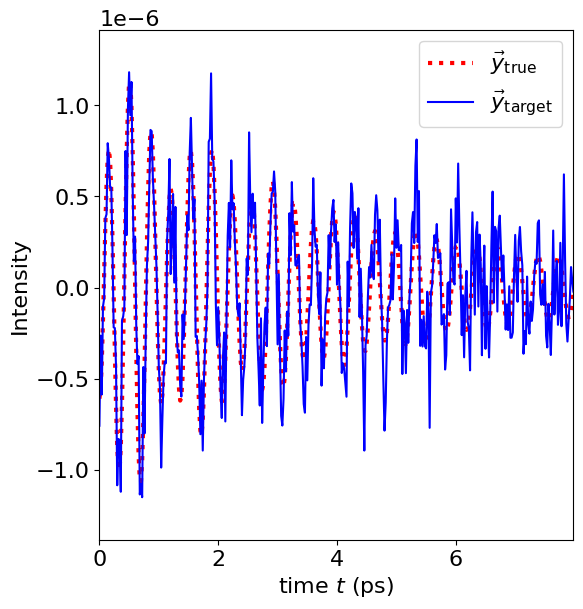

In [6]:
############################################
y_target = y_wn
############################################
y_true_set   = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
y_target_set = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
#
y_sets = [ y_true_set, y_target_set ]
#
fig = Grf_TimeSeries( tt, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-y-orig.pdf' )

データの標準化
* sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

データに対し、以下の前処理を行う
1. 平均値$\mu$を差し引き
2. 単位分散にスケーリング

して、特徴を標準化する。サンプル$x$の標準化は以下の式で計算される。
$$
 z = \frac{x - \mu}{s}
$$
* $\mu$: サンプルの平均値。但し with_mean=False の場合は 0
* $s$学習サンプルの標準偏差。但しwith_std=False の場合は 1

$\bullet$ 多次元配列 (n_samples, n_features) を想定しているため、(n_samples)] である1次元データに適用する場合は、reshapeしておく必要がある。

In [7]:
############################################
scaler = prep.StandardScaler()
#
print( y_target.shape )
print( y_target.reshape([-1,1]).shape )
#
scaler.fit( y_target.reshape([-1,1]) )
#
# ノイズが重畳したデータ
y_target_ss = scaler.transform( y_target.reshape([-1,1]) )
print( y_target_ss.shape )
#
y_target_scale = scaler.scale_[0]
y_target_mean  = scaler.mean_[0]
#
print( 'scaler.mean_  =', y_target_mean  )
print( 'scaler.scale_ =', y_target_scale )
#
y_target_ss = y_target_ss.reshape([-1,])
print( y_target_ss.shape )
print( np.mean( y_target_ss ) )
print( np.std( y_target_ss ) )
#
# 真値データ
y_true_ss = scaler.transform( y_true.reshape([-1,1]) )
y_true_ss = y_true_ss.reshape([-1,])
#
print( np.mean( y_true_ss ) )
print( np.std( y_true_ss ) )
#
# 標準化した真値データとデータとの標準偏差
y_ss_var = np.var(y_target_ss - y_true_ss)
print( 'var(y^SS-y^SS_true) = ', y_ss_var )

(400,)
(400, 1)
(400, 1)
scaler.mean_  = -1.7962225401806694e-09
scaler.scale_ = 4.101989096420784e-07
(400,)
-1.8873791418627663e-17
1.0
-6.661338147750939e-18
0.8998427259255835
var(y^SS-y^SS_true) =  0.23772288273764147


フーリエ変換

フーリエ変換は、周期が$T$の時系列データ
$$
x(t+T)=x(t),\,\,\,t\in[0,T)
$$
を満たす「任意」の周期関数$x(t)$を、
$$
\Delta{}f=\frac{1}{T}
$$
として、次式の様に展開する。
$$
x(t)
=
\sum_{n=1}^{\infty}
\left[
  a_n
  \cos\left(2\pi\;n\;\Delta{}f\;t\right)
  +
  b_n
  \sin\left(2\pi\;n\;\Delta{}f\;t\right)
\right]
$$
展開係数は次式で得られる。
$$
a_n
=
\frac{2}{T}
\int_{-T/2}^{+T/2}
x(\tau)
\cos\left(2\pi\;n\;\Delta{}f\;\tau\right)d\tau
$$

$$
b_n
=
\frac{2}{T}
\int_{-T/2}^{+T/2}
x(\tau)
\sin\left(2\pi\;n\;\Delta{}f\;\tau\right)d\tau
$$

ナイキスト・シャノンのサンプリング定理

実験データでは、時間系列を連続的に測定することは不可能で、一般的に等時間ステップで計測され、また、無限に計測することもかなわない。等時間ステップが$\Delta{}t$で、$M$個の時系列データがあるとする。フーリエ級数の$n$の和で$\infty$までの和を取ることはできないため、和の周波数の上限を設定する必要がある。

* ナイキスト周波数: $f_{\rm Nyquist}$

その周波数の上限は、以下で定義される。
$$
f_{\rm Nyquist}
:=
\frac{1}{2\Delta{}t}
$$
これは$2\Delta{}t$の周期よりも短い周波数は計測できないことを意味する。

* 周波数の分解能: $\Delta{}f$

一方フーリエ級数で展開した際の、周波数の分解能$\Delta{}f$は次式で定義される。
$$
\Delta{}f
:=
\frac{1}{M\Delta{}t}
$$

これは、計測されている時間領域が$M\Delta{}t$であることによる。フーリエ級数の前提として周期$T$で繰り返される任意関数が前提で、計測されている時間領域が最長の周期と考えるためである。つまり、$M\Delta{}t$の時間領域データが繰り返されていることが前提となっている。

numpyのDiscrete Fourier Transform (FFT)
* Reference: https://numpy.org/doc/stable/reference/routines.fft.html
* 実数データのfft: https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html#numpy.fft.rfft

In [8]:
############################################
# 標準化したデータをFFT
#
fft_true     = np.fft.rfft( y_true_ss )
fft_true_re  = np.real( fft_true )
fft_true_im  = np.imag( fft_true )
fft_true_mag = np.abs( fft_true )
# 規格化しておく
fft_true_mag = fft_true_mag / np.amax( fft_true_mag )
fft_true_ang = np.angle( fft_true ) / np.pi * 180.0
#
fft_target     = np.fft.rfft( y_target_ss )
fft_target_re  = np.real( fft_target )
fft_target_im  = np.imag( fft_target )
fft_target_mag = np.abs( fft_target )
# 規格化しておく
fft_target_mag = fft_target_mag / np.amax( fft_target_mag )
fft_target_ang = np.angle( fft_target ) / np.pi * 180.0

フーリエスペクトル等を描画する関数

In [9]:
############################################
def figaxis_FFTspectra( axis, freq, y_sets, freq_max=None, title=None ):
  #
  # 周波数のx軸の設定
  xmax = np.amax( freq )
  #
  if freq_max is not None:
    axis.set_xlim( 0, freq_max )
  else:
    axis.set_xlim( 0, xmax )
  #
  axis.set_xlabel( r'freq. $f$ (THz)' )
  #
  # y軸の設定
  axis.set_ylabel( 'Intensity (normalized)' )
  #
  ymax = 0.0
  #
  # markers
  markers = []
  #
  # yデータセットの描画
  for y_set in y_sets:
    #
    # y_set [ y_data, mode, label, color, width, style ]
    #   mode = 0: plot
    #   mode = 1: marker
    #   mode = 2: vlines
    #
    if   y_set[1]==0:
      # グラフの描画, mode = 0: plot
      axis.plot( freq, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1]==1:
      # marker
      markers.append( y_set )
      #
    elif y_set[1]==2:
      # vlines
      axis.vlines( freq, 0, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
  #
  # y軸の範囲設定
  ybot, ytop = axis.set_ylim( 0.0, 1.2 )
  #
  # markersの描画
  for marker in markers:
    #
    axis.vlines( marker[0], ybot, ytop, label=marker[2], color=marker[3], linewidth=marker[4], linestyle=marker[5] )
  #
  # 凡例
  axis.legend(loc='upper right')
  #
  if title is not None:
    plt.title( title )
  else:
    plt.title( 'FFT spectrum' )
  #
  #
  return

############################################
def Grf_FFTspectra( freq, y_sets, freq_max=None, title=None ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure(figsize=(6,6))
  #
  fig.subplots_adjust(left=0.19, right=0.98, top=0.92, bottom=0.1,wspace=0.25 )
  #
  ####################
  # FFTspectraデータのグラフ
  ax1 = fig.add_subplot(1,1,1)
  #
  figaxis_FFTspectra( ax1, freq, y_sets, freq_max=freq_max )
  #
  ####################
  # グラフの出力
  plt.show()
  #
  return fig

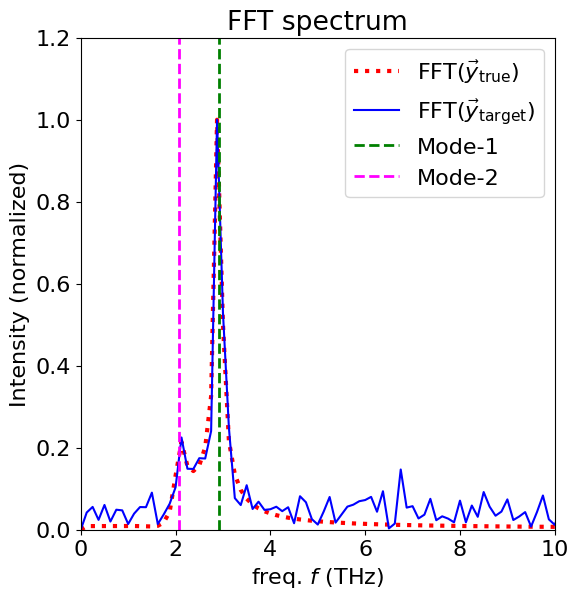

In [10]:
############################################
fft_true_set   = [ fft_true_mag,   0, r'FFT($\vec{y}_{\rm true}$)',   'red',       3, 'dotted' ]
fft_target_set = [ fft_target_mag, 0, r'FFT($\vec{y}_{\rm target}$)', 'blue',    1.5, 'solid'  ]
Mode1_mode     = [ f_1,            1, 'Mode-1',                       'green',   2.0, 'dashed' ]
Mode2_mode     = [ f_2,            1, 'Mode-2',                       'magenta', 2.0, 'dashed' ]
#
fft_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set ]
#
fig = Grf_FFTspectra( ff, fft_sets, freq_max=10 )
#
fig.savefig( FilePath + FileBaseName + '-FFT.pdf' )

フーリエ変換を線形写像で表す
* $f_{n}=n\Delta{}f$ ($n=1,\cdots, N-1$)として
$$
\left(
  \begin{array}{c}
    y_{1}  \\[0.2em]
    y_{2}  \\[0.2em]
    \vdots \\[0.2em]
    \vdots \\[0.2em]
    y_{M}  
  \end{array}
\right)
=
\left(
  \begin{array}{cccccc}
    \color{red}{\sin(2\pi{}f_{1}t_{1})}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_1)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_1)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_1)}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_2)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_2)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_2)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_2)}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_M)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_M)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_M)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_M)}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \color{red}{a_{1}}  \\
    \color{red}{\vdots} \\
    \color{red}{a_{N-1}}  \\
    \color{lightblue}{b_{1}}  \\
    \color{lightblue}{\vdots} \\
    \color{lightblue}{b_{N-1}}  
  \end{array}
\right)
$$

計画行列
$$
\boldsymbol{X}
=
\left(
  \begin{array}{cccccc}
    \color{red}{\sin(2\pi{}f_{1}t_{1})}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_1)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_1)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_1)}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_2)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_2)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_2)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_2)}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\vdots} &
    \color{red}{\ddots} &
    \color{red}{\vdots} &
    \color{lightblue}{\vdots} &
    \color{lightblue}{\ddots} &
    \color{lightblue}{\vdots}
    \\
    \color{red}{\sin(2\pi{}f_{1}t_M)}          &
    \color{red}{\cdots}                          &
    \color{red}{\sin(2\pi{}f_{N-1}t_M)}       &
    \color{lightblue}{\cos(2\pi{}f_{1}t_M)}    &
    \color{lightblue}{\cdots}                    &
    \color{lightblue}{\cos(2\pi{}f_{N-1}t_M)}
  \end{array}
\right)
$$

In [11]:
############################################
# 0 < ff < fmax の周波数成分で計画行列を用意する
#
ff2pi = 2.0 * np.pi * ff[ (ff > 0)&(ff < fmax) ]
print('ff2pi.size =', ff2pi.size )
print('ff2pi =', ff2pi )
#
############################################
# sin(df), sin(2df), ...
# cos(df), cos(2df), ...
#
w_K = ff2pi.size * 2
print('w_K        =', w_K )
#
X = np.zeros( (M, w_K ) )
#
for k in range( ff2pi.size ):
    omega = ff2pi[ k ] * tt
    # print( omega )
    kksin = k
    kkcos = k + ff2pi.size
    X[:, kksin ] = np.sin( omega )
    X[:, kkcos ] = np.cos( omega )
#
print('X.shape    =', X.shape )

ff2pi.size = 199
ff2pi = [  0.78539816   1.57079633   2.35619449   3.14159265   3.92699082
   4.71238898   5.49778714   6.28318531   7.06858347   7.85398163
   8.6393798    9.42477796  10.21017612  10.99557429  11.78097245
  12.56637061  13.35176878  14.13716694  14.9225651   15.70796327
  16.49336143  17.27875959  18.06415776  18.84955592  19.63495408
  20.42035225  21.20575041  21.99114858  22.77654674  23.5619449
  24.34734307  25.13274123  25.91813939  26.70353756  27.48893572
  28.27433388  29.05973205  29.84513021  30.63052837  31.41592654
  32.2013247   32.98672286  33.77212103  34.55751919  35.34291735
  36.12831552  36.91371368  37.69911184  38.48451001  39.26990817
  40.05530633  40.8407045   41.62610266  42.41150082  43.19689899
  43.98229715  44.76769531  45.55309348  46.33849164  47.1238898
  47.90928797  48.69468613  49.48008429  50.26548246  51.05088062
  51.83627878  52.62167695  53.40707511  54.19247327  54.97787144
  55.7632696   56.54866776  57.33406593  58.11946409 

計画行列のヒートマップを描く

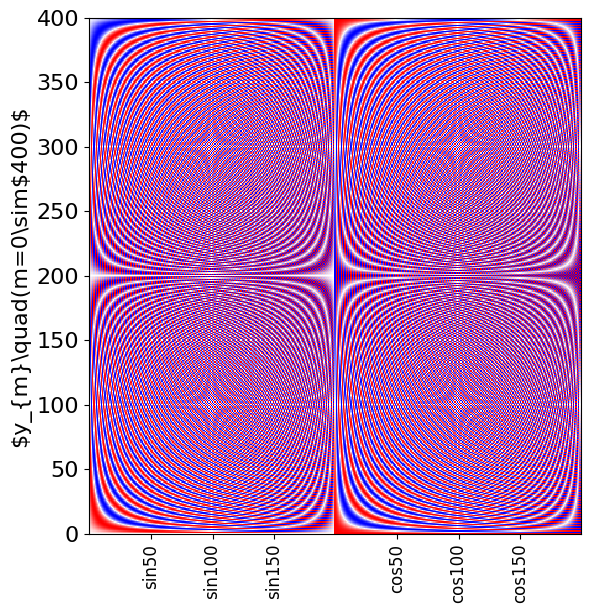

In [12]:
############################################
plt.rcParams["font.size"] = 16
#
fig = plt.figure(figsize=(6,6))
#
fig.subplots_adjust(left=0.15, right=0.97, top=0.98, bottom=0.12, wspace=0.25 )
#
####################
ax1 = fig.add_subplot(1,1,1)
#
heatmap = ax1.pcolor( X, cmap=plt.cm.bwr)
#
ax1.set_ylabel(r'$y_{m}\quad(m=0\sim$%d)$' % M )
#
ax1.set_xticks( [ 50, 100, 150, ff2pi.size+50, ff2pi.size+100, ff2pi.size+150 ] )
ax1.set_xticklabels( ['sin50', 'sin100', 'sin150', 'cos50', 'cos100', 'cos150'],
                     rotation=90, fontsize=12)
#
plt.show()
#
fig.savefig( FilePath + FileBaseName + '-Xmat.pdf' )

フーリエスペクトルは、最大強度で規格化したものとする。

In [13]:
############################################
# 得られた解から強度データを計算
def make_ff_mag_( a0_, w_ ):
  #
  ff_mag_ = np.zeros_like( ff )
  #
  # 切片項
  ff_mag_[ 0 ] = a0_
  #
  idx = 1
  for k in range( ff2pi.size ):
    kksin = k
    kkcos = k + ff2pi.size
    mag_ = np.sqrt( w_[kksin]**2 + w_[kkcos]**2 )
    ff_mag_[ idx ] = mag_
    idx = idx + 1
  #
  # 規格化しておく
  if np.amax(ff_mag_) > 0:
    ff_mag_ = ff_mag_ / np.amax(ff_mag_)
  #
  return ff_mag_

回帰係数 $\hat{\boldsymbol{\omega}}$ と、Criterionsを描画するグラフ関数

In [14]:
############################################
def SubGrf_omega_Criterions( axis, IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None, title_=None ):
  #
  #############
  # omega
  omegas_max = np.amax( np.abs( omegas_ ) )
  #
  axis.set_xscale( 'log' )
  axis.set_xlabel( r'$\alpha$' )
  #
  axis.set_ylabel( r'$\hat{\omega}$' )
  axis.set_ylim( -1.4 * omegas_max, 1.4 * omegas_max )
  #
  axis.plot( alphas_, omegas_ , zorder=0.2)
  axis.plot( alphas_, a0s_, linestyle='dashed', color='gray', zorder=0.3 )
  #
  alphas_left, alphas_right = axis.set_xlim()
  #
  #########
  idx_a_ = None
  print( 'idx_ = ', idx_ )
  #########
  if idx_ is not None:
    #
    idx_a_  = alphas_[ idx_ ]
    idx_L0_ = L0s_[ idx_ ]
    #
    idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
    #
    if IC_idx_ is not None:
      if IC_idx_ == idx_:
        idx_text = '(*) ' + idx_text
      #
    #
  elif IC_idx_ is not None:
    print( 'elif IC_idx_ is not None:' )
    idx_a_  = alphas_[ IC_idx_ ]
    idx_L0_ = L0s_[ IC_idx_ ]
    #
    idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #
  if idx_a_ is not None:
    # 0の場合がある
    if idx_a_ > 0:
      idx_a_mark_ = idx_a_
    else:
      idx_a_mark_ = alphas_left
    #
    axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
    #
    print( idx_text )
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
               idx_text, fontsize=12, rotation=90,
               horizontalalignment='center', verticalalignment='bottom',
               color='white', backgroundcolor='gray', zorder=2.0)
  #
  #############
  # Criterions
  axC = axis.twinx()
  axC.set_ylabel( 'Criterion', color='black' )
  #
  Criterions_max = None
  Criterions_min = None
  #
  for Criterion_set_ in Criterion_sets_:
    #
    label_            = Criterion_set_[0]
    Criterion_type_   = Criterion_set_[1]
    Criterion_data_   = Criterion_set_[2]
    Criterion_color_  = Criterion_set_[3]
    #
    c_max_ = np.amax( Criterion_data_ )
    c_min_ = np.amin( Criterion_data_ )
    #
    if Criterions_max is None:
      Criterions_max = c_max_
    else:
      if c_max_ > Criterions_max:
        Criterions_max = c_max_
    #
    if Criterions_min is None:
      Criterions_min = c_min_
    else:
      if c_min_ < Criterions_min:
        Criterions_min = c_min_
    #
    if Criterion_type_ == 0:  #line
      axC.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linewidth=3)
    elif Criterion_type_ == 1:
      axC.scatter( alphas_, Criterion_data_, label=label_, color=Criterion_color_, s=10)
    elif Criterion_type_ == 2:
      axC.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linestyle='dashed', linewidth=3)
  #
  Criterions_center = (Criterions_max + Criterions_min)/2
  Criterions_width  = (Criterions_max - Criterions_min)/2
  #
  axC.set_ylim( Criterions_center-1.1*Criterions_width, Criterions_center+1.4*Criterions_width )
  #
  plt.legend(loc='upper right', fontsize=12)
  #
  if title_ is None:
    title_ = IC_upper_ + r': $\hat{\omega}$, Criterion'
  #
  plt.title( title_ )
  #
  return
############################################
def Grf_omega_Criterions( IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None  ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure( figsize=(5.5, 5) )
  fig.subplots_adjust(left=0.15, right=0.77, top=0.93, bottom=0.13)
  #
  axis = fig.add_subplot(1,1,1)
  #
  SubGrf_omega_Criterions( axis, IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_ )
  #
  plt.show()
  #
  return fig

Path図を省略した図

In [15]:
############################################
def SubGrf_omega_Criterions_v2( axis, IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None, title_=None ):
  #
  # #############
  # # omega
  # omegas_max = np.amax( np.abs( omegas_ ) )
  # #
  axis.set_xscale( 'log' )
  axis.set_xlabel( r'$\alpha$' )
  # #
  # axis.set_ylabel( r'$\hat{\omega}$' )
  # axis.set_ylim( -1.4 * omegas_max, 1.4 * omegas_max )
  # #
  # axis.plot( alphas_, omegas_ , zorder=0.2)
  # axis.plot( alphas_, a0s_, linestyle='dashed', color='gray', zorder=0.3 )
  # #
  # alphas_left, alphas_right = axis.set_xlim()
  #
  # #########
  # idx_a_ = None
  # print( 'idx_ = ', idx_ )
  # #########
  # if idx_ is not None:
  #   #
  #   idx_a_  = alphas_[ idx_ ]
  #   idx_L0_ = L0s_[ idx_ ]
  #   #
  #   idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #   #
  #   if IC_idx_ is not None:
  #     if IC_idx_ == idx_:
  #       idx_text = '(*) ' + idx_text
  #     #
  #   #
  # elif IC_idx_ is not None:
  #   print( 'elif IC_idx_ is not None:' )
  #   idx_a_  = alphas_[ IC_idx_ ]
  #   idx_L0_ = L0s_[ IC_idx_ ]
  #   #
  #   idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  # #
  # if idx_a_ is not None:
  #   # 0の場合がある
  #   if idx_a_ > 0:
  #     idx_a_mark_ = idx_a_
  #   else:
  #     idx_a_mark_ = alphas_left
  #   #
  #   axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
  #   #
  #   print( idx_text )
  #   (axis_bot, axis_top) = axis.set_ylim()
  #   #
  #   # axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
  #   axis.text( idx_a_mark_, axis_top - 0.05*(axis_top-axis_bot),
  #              idx_text, fontsize=12, rotation=90,
  #              #  horizontalalignment='center', verticalalignment='bottom',
  #              horizontalalignment='center', verticalalignment='top',
  #              color='white', backgroundcolor='gray', zorder=2.0)
  # #
  #############
  # Criterions
  # axC = axis.twinx()
  axis.set_ylabel( 'Criterion', color='black' )
  #
  Criterions_max = None
  Criterions_min = None
  #
  for Criterion_set_ in Criterion_sets_:
    #
    label_            = Criterion_set_[0]
    Criterion_type_   = Criterion_set_[1]
    Criterion_data_   = Criterion_set_[2]
    Criterion_color_  = Criterion_set_[3]
    #
    c_max_ = np.amax( Criterion_data_ )
    c_min_ = np.amin( Criterion_data_ )
    #
    if Criterions_max is None:
      Criterions_max = c_max_
    else:
      if c_max_ > Criterions_max:
        Criterions_max = c_max_
    #
    if Criterions_min is None:
      Criterions_min = c_min_
    else:
      if c_min_ < Criterions_min:
        Criterions_min = c_min_
    #
    if Criterion_type_ == 0:  #line
      axis.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linewidth=3)
    elif Criterion_type_ == 1:
      axis.scatter( alphas_, Criterion_data_, label=label_, color=Criterion_color_, s=10)
    elif Criterion_type_ == 2:
      axis.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linestyle='dashed', linewidth=3)
  #
  Criterions_center = (Criterions_max + Criterions_min)/2
  Criterions_width  = (Criterions_max - Criterions_min)/2
  #
  axis.set_ylim( Criterions_center-1.1*Criterions_width, Criterions_center+1.4*Criterions_width )
  #
  #########
  idx_a_ = None
  print( 'idx_ = ', idx_ )
  #########
  if idx_ is not None:
    #
    idx_a_  = alphas_[ idx_ ]
    idx_L0_ = L0s_[ idx_ ]
    #
    idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
    #
    if IC_idx_ is not None:
      if IC_idx_ == idx_:
        idx_text = '(*) ' + idx_text
      #
    #
  elif IC_idx_ is not None:
    print( 'elif IC_idx_ is not None:' )
    idx_a_  = alphas_[ IC_idx_ ]
    idx_L0_ = L0s_[ IC_idx_ ]
    #
    idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #
  if idx_a_ is not None:
    # 0の場合がある
    if idx_a_ > 0:
      idx_a_mark_ = idx_a_
    else:
      idx_a_mark_ = alphas_left
    #
    axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
    #
    print( idx_text )
    (axis_bot, axis_top) = axis.set_ylim()
    #
    # axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
    axis.text( idx_a_mark_, axis_top - 0.05*(axis_top-axis_bot),
               idx_text, fontsize=12, rotation=90,
               #  horizontalalignment='center', verticalalignment='bottom',
               horizontalalignment='center', verticalalignment='top',
               color='white', backgroundcolor='gray', zorder=2.0)
  #
  plt.legend(loc='upper left', fontsize=12)
  #
  if title_ is None:
    title_ = IC_upper_ + r': $\hat{\omega}$, Criterion'
  #
  plt.title( title_ )
  #
  return
############################################
def Grf_omega_Criterions_v2( IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None  ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure( figsize=(5.5, 5) )
  fig.subplots_adjust(left=0.15, right=0.77, top=0.93, bottom=0.13)
  #
  axis = fig.add_subplot(1,1,1)
  #
  SubGrf_omega_Criterions_v2( axis, IC_upper_, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_ )
  #
  plt.show()
  #
  return fig

情報量規準の確認結果で、指定したidxの結果のグラフを出力する関数

In [16]:
############################################
def Grf_ICsurveySummary( dictICsurvey_, idx_=None ):
  #
  # dict_keys(['dictIC', 'IC_upper', 'y_target', 'y_target_ss', 'fft_target_mag', 'noise_variance',
  # 'IC_alpha', 'alphas', 'criterions', 'IC_idx', 'coef_s', 'a0_s', 'L0_s', 'L0_w_s',
  # 'fft_mag_s', 'fft_mag_RMSD_s',
  # 'yreg_s', 'yreg_RMSD_target_s', 'yreg_RMSD_true_s',
  # 'IC_0_s', 'IC_1_s', 'IC_2_s', 'IC_check_s'])
  ##########################################
  IC_upper_ = dictICsurvey_[ 'IC_upper' ]
  #
  L0s_      = dictICsurvey_[ 'L0_s' ]
  coef_s_   = dictICsurvey_[ 'coef_s' ]
  a0_s_     = dictICsurvey_[ 'a0_s' ]
  # 'yreg_s',
  # 'yreg_RMSD_target_s',
  # 'yreg_RMSD_true_s',
  # 'wspec_RMSD_true_s',
  IC_0_s_     = dictICsurvey_[ 'IC_0_s' ]
  IC_1_s_     = dictICsurvey_[ 'IC_1_s' ]
  IC_2_s_     = dictICsurvey_[ 'IC_2_s' ]
  # 'IC_check_s',
  alphas_     = dictICsurvey_[ 'alphas'     ]
  IC_alpha_   = dictICsurvey_[ 'IC_alpha'   ]
  IC_idx_     = dictICsurvey_[ 'IC_idx'     ]
  criterions_ = dictICsurvey_[ 'criterions' ]
  #
  ##########################################
  if idx_ is None:
    idx_ = np.where( alphas_ == IC_alpha_ )[0][0]
  #
  a_                = dictICsurvey_[ 'alphas'             ][ idx_ ]
  yreg_             = dictICsurvey_[ 'yreg_s'             ][ idx_ ]
  yreg_RMSD_target_ = dictICsurvey_[ 'yreg_RMSD_target_s' ][ idx_ ]
  fft_mag_          = dictICsurvey_[ 'fft_mag_s'          ][ idx_ ]
  fft_mag_L0_       = dictICsurvey_[ 'L0_s'               ][ idx_ ]
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.94, top=0.87, bottom=0.12, wspace=0.27)
  #
  ##########################################
  y_true_set   = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
  y_target_set = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
  y_reg_set_label = r'$\hat{\vec{y}}$:RMSD=%.2E' % yreg_RMSD_target_
  y_reg_set    = [ yreg_,    y_reg_set_label,           'green',1.5, 'dashed' ]
  #
  y_sets    = [ y_true_set, y_target_set, y_reg_set ]
  #
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  #
  title1 = r'(a) $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  figaxis_TimeSeries( ax_y, tt, y_sets, title=title1 )  #
  #
  ##########################################
  fft_true_set   = [ fft_true_mag,   0, r'FFT($\vec{y}_{\rm true}$)',   'red',       3, 'dotted' ]
  fft_target_set = [ fft_target_mag, 0, r'FFT($\vec{y}_{\rm target}$)', 'blue',    1.5, 'solid'  ]
  Mode1_mode     = [ f_1,            1, 'Mode-1',                       'green',   2.0, 'dashed' ]
  Mode2_mode     = [ f_2,            1, 'Mode-2',                       'magenta', 2.0, 'dashed' ]
  fft_mag_set_label = r'FFT($\vec{y}$):$L_{0}$=%d' % fft_mag_L0_
  fft_mag_set    = [ fft_mag_,       2, fft_mag_set_label,              'green',   2.0, 'solid'  ]
  #
  fft_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set, fft_mag_set ]
  #
  ###########
  ax_fft = fig.add_subplot(1, 3, 2)
  #
  title2 = r'(b) ${\rm FFT}: \vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  figaxis_FFTspectra( ax_fft, ff, fft_sets, freq_max=10, title=title2 )
  #
  ##########################################
  Criterion_sets_ = [ [ IC_upper_,         0, criterions_, 'red'   ],
                      [ r'${\rm IC}_{1}$', 2, IC_0_s_,     'black' ],
                      [ r'${\rm IC}_{2}$', 2, IC_1_s_,     'green' ],
                      [ r'${\rm IC}_{3}$', 2, IC_2_s_,     'orange'] ]
  #
  ax_summary = fig.add_subplot(1, 3, 3)
  #
  title3 = '(c) ' + IC_upper_ + r': $\hat{\omega}$, Criterions'
  SubGrf_omega_Criterions( ax_summary, IC_upper_, alphas_, coef_s_, a0_s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_, title_=title3 )
  #
  ###########
  plt.show()
  ###########
  return fig

Path図を省略した図

In [17]:
############################################
def Grf_ICsurveySummary_v2( dictICsurvey_, idx_=None ):
  #
  # dict_keys(['dictIC', 'IC_upper', 'y_target', 'y_target_ss', 'fft_target_mag', 'noise_variance',
  # 'IC_alpha', 'alphas', 'criterions', 'IC_idx', 'coef_s', 'a0_s', 'L0_s', 'L0_w_s',
  # 'fft_mag_s', 'fft_mag_RMSD_s',
  # 'yreg_s', 'yreg_RMSD_target_s', 'yreg_RMSD_true_s',
  # 'IC_0_s', 'IC_1_s', 'IC_2_s', 'IC_check_s'])
  ##########################################
  IC_upper_ = dictICsurvey_[ 'IC_upper' ]
  #
  L0s_      = dictICsurvey_[ 'L0_s' ]
  coef_s_   = dictICsurvey_[ 'coef_s' ]
  a0_s_     = dictICsurvey_[ 'a0_s' ]
  # 'yreg_s',
  # 'yreg_RMSD_target_s',
  # 'yreg_RMSD_true_s',
  # 'wspec_RMSD_true_s',
  IC_0_s_     = dictICsurvey_[ 'IC_0_s' ]
  IC_1_s_     = dictICsurvey_[ 'IC_1_s' ]
  IC_2_s_     = dictICsurvey_[ 'IC_2_s' ]
  # 'IC_check_s',
  alphas_     = dictICsurvey_[ 'alphas'     ]
  IC_alpha_   = dictICsurvey_[ 'IC_alpha'   ]
  IC_idx_     = dictICsurvey_[ 'IC_idx'     ]
  criterions_ = dictICsurvey_[ 'criterions' ]
  #
  ##########################################
  if idx_ is None:
    idx_ = np.where( alphas_ == IC_alpha_ )[0][0]
  #
  a_                = dictICsurvey_[ 'alphas'             ][ idx_ ]
  yreg_             = dictICsurvey_[ 'yreg_s'             ][ idx_ ]
  yreg_RMSD_target_ = dictICsurvey_[ 'yreg_RMSD_target_s' ][ idx_ ]
  fft_mag_          = dictICsurvey_[ 'fft_mag_s'          ][ idx_ ]
  fft_mag_L0_       = dictICsurvey_[ 'L0_s'               ][ idx_ ]
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.94, top=0.87, bottom=0.12, wspace=0.27)
  #
  ##########################################
  y_true_set   = [ y_true,   r'$\vec{y}_{\rm true}$',   'red',    3, 'dotted' ]
  y_target_set = [ y_target, r'$\vec{y}_{\rm target}$', 'blue', 1.5, 'solid'  ]
  y_reg_set_label = r'$\hat{\vec{y}}$:RMSD=%.2E' % yreg_RMSD_target_
  y_reg_set    = [ yreg_,    y_reg_set_label,           'green',1.5, 'dashed' ]
  #
  y_sets    = [ y_true_set, y_target_set, y_reg_set ]
  #
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  #
  title1 = r'(a) $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  figaxis_TimeSeries( ax_y, tt, y_sets, title=title1 )  #
  #
  ##########################################
  fft_true_set   = [ fft_true_mag,   0, r'FFT($\vec{y}_{\rm true}$)',   'red',       3, 'dotted' ]
  fft_target_set = [ fft_target_mag, 0, r'FFT($\vec{y}_{\rm target}$)', 'blue',    1.5, 'solid'  ]
  Mode1_mode     = [ f_1,            1, 'Mode-1',                       'green',   2.0, 'dashed' ]
  Mode2_mode     = [ f_2,            1, 'Mode-2',                       'magenta', 2.0, 'dashed' ]
  fft_mag_set_label = r'FFT($\vec{y}$):$L_{0}$=%d' % fft_mag_L0_
  fft_mag_set    = [ fft_mag_,       2, fft_mag_set_label,              'green',   2.0, 'solid'  ]
  #
  fft_sets = [ Mode1_mode, Mode2_mode, fft_true_set, fft_target_set, fft_mag_set ]
  #
  ###########
  ax_fft = fig.add_subplot(1, 3, 2)
  #
  title2 = r'(b) ${\rm FFT}: \vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  figaxis_FFTspectra( ax_fft, ff, fft_sets, freq_max=10, title=title2 )
  #
  ##########################################
  Criterion_sets_ = [ [ IC_upper_,         0, criterions_, 'red'   ],
                      [ r'${\rm IC}_{1}$', 2, IC_0_s_,     'black' ],
                      [ r'${\rm IC}_{2}$', 2, IC_1_s_,     'green' ],
                      [ r'${\rm IC}_{3}$', 2, IC_2_s_,     'orange'] ]
  #
  ax_summary = fig.add_subplot(1, 3, 3)
  #
  title3 = '(c) ' + IC_upper_ + r': $\hat{\omega}$, Criterions'
  SubGrf_omega_Criterions_v2( ax_summary, IC_upper_, alphas_, coef_s_, a0_s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_, title_=title3 )
  #
  ###########
  plt.show()
  ###########
  return fig

情報量規準 (Information Crieterion)
* 参考文献
  * B. H. Zou, T. Hastie, R. Tibshirani, On The "Degrees of Freedom" of The LASSO", The Annals of Statistics **35**, 2173 (2007). http://dx.doi.org/10.1214/009053607000000127
  * 小西 貞則, 北川 源四郎, 情報量規準 (シリーズ・予測と発見の科学), 朝倉書店 (2004). ISBN-10 : 4254127820
  * 樺島祥介, 北川源四郎, 甘利俊一, 赤池弘次, 下平英寿, 土谷 隆, 室田一雄, 赤池情報量規準AIC―モデリング・予測・知識発見, 共立出版 (2007). ISBN-10 : 4320121902

scikit-learn の LassoLarsIC

* 尤度項

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、尤度項$P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})$は

  $$
    P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})
    =
    \left(
      \frac{1}{
        \sigma_{\rm noise}
        \sqrt{2\pi}
      }
    \right)^{M}
    \exp
    \left[
    -
    \frac{
      \left(
        \boldsymbol{y}
        -
        \hat{\boldsymbol{y}}(\hat{\boldsymbol{\omega}})
      \right)^{2}
    }{
      2\sigma_{\rm noise}^{2}
    }
  \right]
  $$

  である。ここで $\boldsymbol{y}$ は $M$ 個の測定値からなる解析対象データベクトル、$\hat{\boldsymbol{y}}$ は、推定された説明変数 $\hat{\boldsymbol{\omega}}$ で得られる推定(再現)データである。よって以下となる。

  $$
    -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
    =
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
    +
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}
  $$

* モデルの自由度: $\widehat{df}(\boldsymbol{\omega})$

  * LassoLarsICでは、モデルの自由度として説明変数$\boldsymbol{\omega}$の非ゼロ要素数を採用している。
  $$
   \widehat{df}(\boldsymbol{\omega})
   =
   {\rm L}_{0}(\boldsymbol{\omega})
  $$
  ただしLassoLarsICでは、このモデルの自由度として切片項は含めていない。

* AIC (赤池情報量規準)

  $${\rm AIC}
  =
  -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
  +
  2
  \,
  \widehat{df}(\boldsymbol{\omega})
  $$

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、次式となる。

  $${\rm AIC}
  =
  \underbrace{
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
  }_{{\rm IC}_{1}}
  +
  \underbrace{
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}  
  }_{{\rm IC}_{2}}
  +
  \underbrace{
    2
    \,
    \widehat{df}(\boldsymbol{\omega})
  }_{{\rm IC}_{3}}
  $$

* BIC (ベイズ情報量規準)

  $${\rm BIC}
  =
  -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
  +
  \ln(M)
  \,
  \widehat{df}(\boldsymbol{\omega})
  $$

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、次式となる。

  $${\rm BIC}
  =
  \underbrace{
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
  }_{{\rm IC}_{1}}
  +
  \underbrace{
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}  
  }_{{\rm IC}_{2}}
  +
  \underbrace{
    \ln(M)
    \,
    \widehat{df}(\boldsymbol{\omega})
  }_{{\rm IC}_{3}}
  $$

* $\sigma_{\rm noise}^{2}$

  データに重畳する正規分布の分散 $\sigma_{\rm noise}^{2}$ は、一般的には未知である。その場合LassoLarsICでは、
  
  * 説明変数$a_{0}$, $\boldsymbol{\omega}$の解（$\boldsymbol{\omega}_{\rm OLS}$）を、一旦 OLS(一般化最小二乗法)で得て、その再現データ $\check{\boldsymbol{y}}(\boldsymbol{\omega}_{\rm OLS})$ を得る。

  * 説明変数の数 $p$ を、切片項も含めてカウントする。

  これらを用いて $\sigma_{\rm noise}^{2}$ を次式とする。

  $$
  \sigma_{\rm noise}^{2}
  =
  \frac{1}{M-p}
  \sum_{m=1}^{M}
  \left[
    y_m
    -
    \check{y}_{m}(\boldsymbol{\omega}_{\rm OLS})
  \right]^{2}  
  $$

  ただし $M > p$でなければならない。

LassoLarsIC

Larsアルゴリズムを用いたLasso回帰における、情報量規準(BIC/AIC)を用いたモデル選択

$$
\hat{\tilde{\boldsymbol{\omega}}}
=
{\rm arg min}_{\tilde{\boldsymbol{\omega}}}
\left(
  \frac{1}{2M}
  \left\|
    \boldsymbol{y}
    -
    \tilde{\boldsymbol{X}}
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
  +
  \alpha
  \left\|
    \tilde{\boldsymbol{\omega}}
  \right\|_1
\right)
$$

* sklearn.linear_model.LassoLarsIC
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html
* 引数
  * criterion: 'aic' / 'bic' (default='aic')
  * fit_intercept: 切片を計算するか否か
  * noise_variance: データに重畳する正規分布ノイズの分散 (default=None)。Noneの場合は、内部でOLSによりノイズ分散を推定する。

* 返値
  * coef_: $\hat{\boldsymbol{\omega}}(\alpha_{\rm IC})$の配列, (n_features,)
  * intercept_: 切片値
  * alpha_: 情報量規準で選択された$\alpha_{\rm IC}$
  * alphas_: 計算に用いられた$\alpha$テーブル
  * criterion_: 計算に用いられた各$\alpha$における情報量規準の値
  * noise_variance: 推定(用いた)正規分布ノイズの分散

In [18]:
############################################
# LassoLarsIC を実行する関数
############################################
def dictICriterion( IC_, y_, XX_, fit_intercept=True, noise_variance=None ):
  #
  ##########################################
  dictIC = {}
  #
  ##########################################
  # y_ の標準化
  scaler = prep.StandardScaler()
  #
  scaler.fit( y_.reshape([-1,1]) )
  #
  # 解析する標準化されたデータ
  y_ss = scaler.transform( y_.reshape([-1,1]) )
  y_ss = y_ss.reshape([-1,])
  #
  y_sacler_scale = scaler.scale_[0]
  y_sacler_mean  = scaler.mean_[0]
  #
  dictIC[ 'y_target'       ] = y_
  dictIC[ 'y_target_ss'    ] = y_ss
  dictIC[ 'y_scaler'       ] = scaler
  dictIC[ 'y_sacler_scale' ] = y_sacler_scale
  dictIC[ 'y_sacler_mean'  ] = y_sacler_mean
  dictIC[ 'Xmat'           ] = XX_
  #
  ##########################################
  # y_ss のFFT
  fft_ss     = np.fft.rfft( y_ss )
  fft_ss_mag = np.abs( fft_ss )
  # 規格化しておく
  fft_ss_mag = fft_ss_mag / np.amax( fft_ss_mag )
  #
  dictIC[ 'fft_mag' ] = fft_ss_mag
  #
  ##########################################
  IC_upper = str.upper( IC_ )
  IC_lower = str.lower( IC_ )
  #
  dictIC[ 'IC_upper' ] = IC_upper
  #
  ##########################################
  print( '-- ' + IC_upper + ' ------------------' )
  #
  ##########################################
  ic_obj = lm.LassoLarsIC( criterion = IC_lower, fit_intercept=fit_intercept, noise_variance=noise_variance )
  ic_obj.fit( XX_, y_ss )
  #
  ##########################################
  IC_alpha_      = ic_obj.alpha_
  IC_coef_       = ic_obj.coef_
  IC_intercept_  = ic_obj.intercept_
  IC_noise_var_  = ic_obj.noise_variance_
  #
  dictIC[ 'IC_alpha' ]     = IC_alpha_
  dictIC[ 'IC_coef' ]      = IC_coef_
  dictIC[ 'IC_intercept' ] = IC_intercept_
  dictIC[ 'IC_noise_var' ] = IC_noise_var_
  #
  alphas_        = ic_obj.alphas_
  criterions_    = ic_obj.criterion_
  #
  dictIC[ 'alphas' ]     = alphas_
  dictIC[ 'criterions' ] = criterions_
  #
  ##########################################
  IC_yreg_ss    = XX_ @ IC_coef_ + IC_intercept_
  # IC_yreg_      = scaler.inverse_transform( IC_yreg_ss.reshape([-1,1]) )
  # IC_yreg_RMSD_ = np.std( IC_yreg_ - y_ )
  # print( 'IC_yreg_RMSD_ = ', IC_yreg_RMSD_ )
  #
  IC_yreg_      = IC_yreg_ss * y_sacler_scale + y_sacler_mean
  IC_yreg_RMSD_ = np.std( IC_yreg_ - y_ )
  # print( 'IC_yreg_RMSD_ = ', IC_yreg_RMSD_ )
  #
  dictIC[ 'IC_yreg' ]     = IC_yreg_
  dictIC[ 'IC_yreg_RMSD' ] = IC_yreg_RMSD_
  #
  ##########################################
  IC_fft_mag_      = make_ff_mag_( IC_intercept_, IC_coef_ )
  IC_fft_mag_RMSD_ = np.std( IC_fft_mag_ - fft_ss_mag )
  #
  dictIC[ 'IC_fft_mag_RMSD' ] = IC_fft_mag_RMSD_
  #
  ##########################################
  IC_L0_ = np.count_nonzero( IC_fft_mag_ )
  #
  dictIC[ 'IC_L0' ] = IC_L0_
  #
  ##########################################
  print( '%s : alpha=%.3E : L0=%3d : RMSD_y=%.3E : RMSD_fft=%.3E ' % (IC_upper, IC_alpha_, IC_L0_, IC_yreg_RMSD_, IC_fft_mag_RMSD_) )
  #
  print()
  #
  print( 'noise_var = ', IC_noise_var_ )
  #
  return dictIC

dictICriterion() の実行経過を元に、情報量規準を確認する関数。

$\alpha$テーブルに従って、LassoLars回帰を繰り返す

$$
\hat{\tilde{\boldsymbol{\omega}}}
=
{\rm arg min}_{\tilde{\boldsymbol{\omega}}}
\left(
  \frac{1}{2M}
  \left\|
    \boldsymbol{y}
    -
    \tilde{\boldsymbol{X}}
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
  +
  \alpha
  \left\|
    \tilde{\boldsymbol{\omega}}
  \right\|_1
\right)
$$

* $\hat{\tilde{\boldsymbol{\omega}}}$を使った再現データ

$$
\hat{\boldsymbol{y}}
=
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+
\hat{\tilde{a}}_{0}
$$

* 以下の残差を求める

  * $\textrm{RMSD}(\boldsymbol{y} -\hat{\boldsymbol{y}})$ : 解析対象データ(ノイズ重畳)$\boldsymbol{y}$に対する、$\hat{\boldsymbol{y}}$の残差:

  * $\textrm{RMSD}(\boldsymbol{y}_{\rm true} -\hat{\boldsymbol{y}})$ : 真値データ$\boldsymbol{y}_{\rm true}$に対する、$\hat{\boldsymbol{y}}$の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

* 標準化して得られた $\hat{\tilde{\boldsymbol{\omega}}}$, $\hat{\tilde{a}_{0}}$ を $\hat{\boldsymbol{\omega}}$, $\hat{a_{0}}$に戻す

  $$\hat{\boldsymbol{\omega}}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  $$

  $$\hat{a}_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
  $$

  * $\textrm{RMSD}(\boldsymbol{\omega}_{\rm true} -\hat{\boldsymbol{\omega}})$ : 真値の$\boldsymbol{\omega}_{\rm true}$に対する$\hat{\boldsymbol{\omega}}$ の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

In [19]:
############################################
def dictICsurvey( dictIC_, fit_intercept=True, noise_variance=None ):
  #
  ##########################################
  dictICsurvey_ = {}
  ##########################################
  dictICsurvey_[ 'dictIC' ]   = dictIC_
  ##########################################
  IC_upper = dictIC_[ 'IC_upper']
  dictICsurvey_[ 'IC_upper' ] = IC_upper
  ##########################################
  scaler      = dictIC_[ 'y_scaler'    ]
  y_sacler_scale = dictIC_[ 'y_sacler_scale' ]
  y_sacler_mean  = dictIC_[ 'y_sacler_mean'  ]
  #
  y_target    = dictIC_[ 'y_target'    ]
  y_target_ss = dictIC_[ 'y_target_ss' ]
  XX          = dictIC_[ 'Xmat'        ]
  #
  fft_ss_mag  = dictIC_[ 'fft_mag'     ]
  #
  dictICsurvey_[ 'y_target'       ] = y_target
  dictICsurvey_[ 'y_target_ss'    ] = y_target_ss
  dictICsurvey_[ 'fft_target_mag' ] = fft_ss_mag
  #
  ##########################################
  # OLSを用いて noise_varianceの推定
  ##########################################
  if noise_variance is None:
    reg = lm.LinearRegression()
    #
    reg.fit( XX, y_target_ss )
    #
    OLS_w  = reg.coef_
    OLS_a0 = reg.intercept_
    #
    OLS_p = len( OLS_w )
    if fit_intercept:
      OLS_p = OLS_p + 1
    #
    # 再現データ
    OLS_yreg = XX @ OLS_w + OLS_a0
    #
    # LassoLarsIC では、これで推定されたものが、noise_variance_として返される
    noise_variance = np.sum( (y_target_ss - OLS_yreg)**2 ) / (M - OLS_p)
    #
  print( 'noise_variance = %.4E' % noise_variance )
  #
  print( 'IC_noise_var   = %.4E' % dictIC_['IC_noise_var'] )
  #
  dictICsurvey_[ 'noise_variance'  ] = noise_variance
  #
  ##########################################
  # 各alphaで AIC/BICを検算
  ##########################################
  lars_coef_s             = []
  lars_a0_s               = []
  lars_L0_s               = []
  lars_L0_w_s             = []
  lars_fft_mag_s          = []
  lars_fft_mag_RMSD_s     = []
  lars_yreg_s             = []
  lars_yreg_RMSD_target_s = []
  lars_yreg_RMSD_true_s   = []
  IC_0_s                  = []
  IC_1_s                  = []
  IC_2_s                  = []
  IC_check_s              = []
  #
  ##########################################
  print( '  %3s: %-10s : %-10s : %-3s : %-10s : %-10s : %-10s : %-10s : %-10s : %-10s : %-10s' %
        ('idx', 'alpha', 'criterion', 'L0', 'fftRMSD', 'RMSDtarget', 'RMSDtrue',  'ICcheck', 'IC_0', 'IC_1', 'IC_2' ) )
  #
  ##########################################
  IC_alpha_   = dictIC_[ 'IC_alpha' ]
  alphas_     = dictIC_[ 'alphas' ]
  criterions_ = dictIC_[ 'criterions' ]
  #
  dictICsurvey_[ 'IC_alpha'   ] = IC_alpha_
  dictICsurvey_[ 'alphas'     ] = alphas_
  dictICsurvey_[ 'criterions' ] = criterions_
  #
  ##########################################
  IC_idx_     = None
  #
  for idx in range( len( alphas_ ) ):
    #
    # if idx % idx_step != 0:
    #    continue
    #
    a         = alphas_[ idx ]
    criterion = criterions_[ idx ]
    #
    ########################################
    if a == IC_alpha_ :
      print( '* %3d: %.4E : %.4E ' % (idx, a, criterion), end='' )
      IC_idx_ = idx
    else:
      print( '  %3d: %.4E : %.4E ' % (idx, a, criterion), end='' )
    #
    ########################################
    # Lars
    ########################################
    lars = lm.LassoLars( alpha = a, fit_intercept=fit_intercept )
    lars.fit( XX, y_target_ss )
    #
    lars_w  = lars.coef_
    lars_a0 = lars.intercept_
    #
    lars_coef_s.append(lars_w)
    lars_a0_s.append(lars_a0)
    #
    lars_L0_w = np.count_nonzero( lars_w )
    lars_L0_w_s.append( lars_L0_w )
    #
    ########################################
    # 再現データ
    lars_yreg_ss = XX @ lars_w + lars_a0
    #
    lars_yreg_ = lars_yreg_ss * y_sacler_scale + y_sacler_mean
    lars_yreg_s.append( lars_yreg_ )
    #
    ########################################
    # fft / L0
    ########################################
    lars_fft_mag       = make_ff_mag_( lars_a0, lars_w )
    lars_fft_mag_RMSD_ = np.std( lars_fft_mag - fft_ss_mag )
    #
    lars_L0 = np.count_nonzero( lars_fft_mag )
    #
    print( ': %3d ' % lars_L0, end='' )
    print( ': %.4E ' % (lars_fft_mag_RMSD_), end='' )
    #
    lars_L0_s.append( lars_L0 )
    lars_fft_mag_s.append( lars_fft_mag )
    lars_fft_mag_RMSD_s.append( lars_fft_mag_RMSD_ )
    #
    ########################################
    # 再現データ RMSD
    # lars_yreg_RMSD_target_ = np.std( lars_yreg_ - y_target_ss )
    # lars_yreg_RMSD_true_   = np.std( lars_yreg_ - y_true_ss   )
    # print( ': %.4E : %.4E ' % (lars_yreg_RMSD_target_, lars_yreg_RMSD_true_), end='' )
    #
    lars_yreg_RMSD_target_ = np.std( lars_yreg_ - y_target )
    lars_yreg_RMSD_true_   = np.std( lars_yreg_ - y_true   )
    print( ': %.4E : %.4E ' % (lars_yreg_RMSD_target_, lars_yreg_RMSD_true_), end='' )
    #
    lars_yreg_RMSD_target_s.append( lars_yreg_RMSD_target_ )
    lars_yreg_RMSD_true_s.append( lars_yreg_RMSD_true_ )
    #
    ########################################
    # IC検算
    ##########################################
    IC_0    = M * np.log( 2 * np.pi * noise_variance )
    IC_1    = np.sum( (y_target_ss - lars_yreg_ss)**2 ) / noise_variance
    if IC_upper == 'AIC':
      IC_2  = 2 * lars_L0_w # lars_L0
    elif IC_upper == 'BIC':
      IC_2  = np.log( M ) * lars_L0_w # lars_L0
    else:
      IC_2  = 0
    #
    IC_check = IC_0 + IC_1 + IC_2
    print( ': %.4E : %.4E : %.4E : %.4E ' % (IC_check, IC_0, IC_1, IC_2), end='' )
    #
    IC_0_s.append( IC_0 )
    IC_1_s.append( IC_1 )
    IC_2_s.append( IC_2 )
    IC_check_s.append( IC_check )
    #
    ########################################
    # The end of each alpha
    ########################################
    if a == IC_alpha_ :
      print( '*' )
    else:
      print()
  #
  ##########################################
  dictICsurvey_[ 'IC_idx'             ] = IC_idx_
  dictICsurvey_[ 'coef_s'             ] = lars_coef_s
  dictICsurvey_[ 'a0_s'               ] = lars_a0_s
  dictICsurvey_[ 'L0_s'               ] = lars_L0_s
  dictICsurvey_[ 'L0_w_s'             ] = lars_L0_w_s
  dictICsurvey_[ 'fft_mag_s'          ] = lars_fft_mag_s
  dictICsurvey_[ 'fft_mag_RMSD_s'     ] = lars_fft_mag_RMSD_s
  dictICsurvey_[ 'yreg_s'             ] = lars_yreg_s
  dictICsurvey_[ 'yreg_RMSD_target_s' ] = lars_yreg_RMSD_target_s
  dictICsurvey_[ 'yreg_RMSD_true_s'   ] = lars_yreg_RMSD_true_s
  dictICsurvey_[ 'IC_0_s'             ] = IC_0_s
  dictICsurvey_[ 'IC_1_s'             ] = IC_1_s
  dictICsurvey_[ 'IC_2_s'             ] = IC_2_s
  dictICsurvey_[ 'IC_check_s'         ] = IC_check_s
  #
  return dictICsurvey_

---
AICの実行 (noise_varianceを指定せず、推定させてみる)

In [20]:
############################################
IC = 'aic' # 'bic'
############################################
# AICの実行
dictAIC = dictICriterion( IC, y_target, X )
# AIC : alpha=9.499E-03 : L0=159 : RMSD_y=9.455E-08 : RMSD_fft=5.212E-03
# noise_var =  0.10194687245749737
#
# dictAIC = dictICriterion( IC, y_target, X, noise_variance=y_ss_var )
# AIC : alpha=2.504E-02 : L0= 62 : RMSD_y=1.816E-07 : RMSD_fft=1.680E-02
# noise_var =  0.23772288273764147
#
print( dictAIC.keys() )

-- AIC ------------------
AIC : alpha=9.499E-03 : L0=159 : RMSD_y=9.455E-08 : RMSD_fft=5.212E-03 

noise_var =  0.10194687245749726
dict_keys(['y_target', 'y_target_ss', 'y_scaler', 'y_sacler_scale', 'y_sacler_mean', 'Xmat', 'fft_mag', 'IC_upper', 'IC_alpha', 'IC_coef', 'IC_intercept', 'IC_noise_var', 'alphas', 'criterions', 'IC_yreg', 'IC_yreg_RMSD', 'IC_fft_mag_RMSD', 'IC_L0'])


In [21]:
############################################
dictAICsurvey = dictICsurvey( dictAIC )
# dictAICsurvey = dictICsurvey( dictAIC, noise_variance=y_ss_var )
#
print( dictAICsurvey.keys() )

noise_variance = 1.0195E-01
IC_noise_var   = 1.0195E-01
  idx: alpha      : criterion  : L0  : fftRMSD    : RMSDtarget : RMSDtrue   : ICcheck    : IC_0       : IC_1       : IC_2      
    0: 3.8649E-01 : 3.7454E+03 :   1 : 8.3503E-02 : 4.1020E-07 : 3.6911E-07 : 3.7454E+03 : -1.7817E+02 : 3.9236E+03 : 0.0000E+00 
    1: 3.0474E-01 : 3.3040E+03 :   2 : 5.0442E-02 : 3.8632E-07 : 3.4106E-07 : 3.3040E+03 : -1.7817E+02 : 3.4802E+03 : 2.0000E+00 
    2: 2.5697E-01 : 2.8849E+03 :   2 : 5.0442E-02 : 3.6220E-07 : 3.1330E-07 : 2.8849E+03 : -1.7817E+02 : 3.0590E+03 : 4.0000E+00 
    3: 1.2249E-01 : 1.6855E+03 :   3 : 3.7774E-02 : 2.8225E-07 : 2.1856E-07 : 1.6855E+03 : -1.7817E+02 : 1.8577E+03 : 6.0000E+00 
    4: 1.0510E-01 : 1.5633E+03 :   4 : 3.6465E-02 : 2.7265E-07 : 2.0680E-07 : 1.5633E+03 : -1.7817E+02 : 1.7335E+03 : 8.0000E+00 
    5: 9.3127E-02 : 1.4722E+03 :   5 : 3.5032E-02 : 2.6523E-07 : 1.9651E-07 : 1.4722E+03 : -1.7817E+02 : 1.6403E+03 : 1.0000E+01 
    6: 7.9322E-02 : 1.3621E+03 :   6

推定された $\alpha_{\rm AIC}$の解析結果のまとめ

idx_ =  232
(*) $\alpha=$9.50E-03$, L_{0}=159$


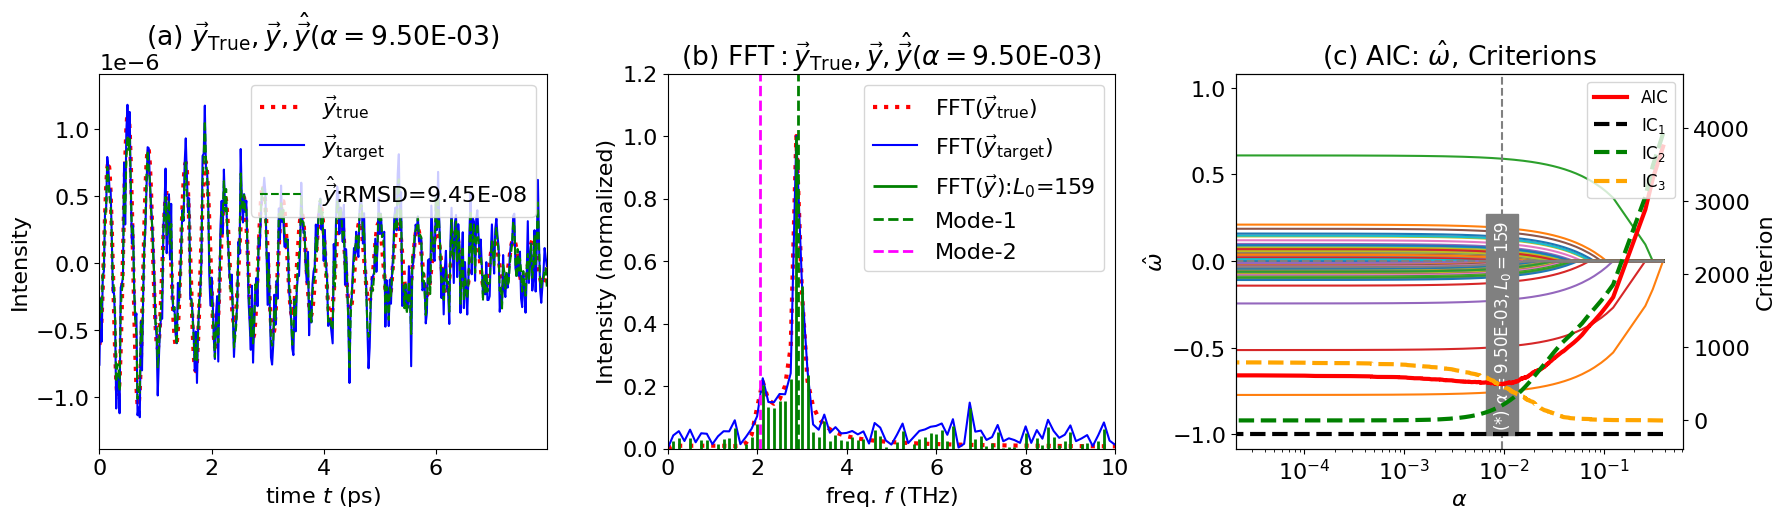

In [22]:
############################################
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
#
############################################
# 推定された $\alpha_{\rm AIC}$の解析結果のまとめ
fig = Grf_ICsurveySummary( dictAICsurvey ) #, idx_=10 )
#
pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-Selected-summary-02.pdf'
fig.savefig( pdfname )

idx_ =  232
(*) $\alpha=$9.50E-03$, L_{0}=159$


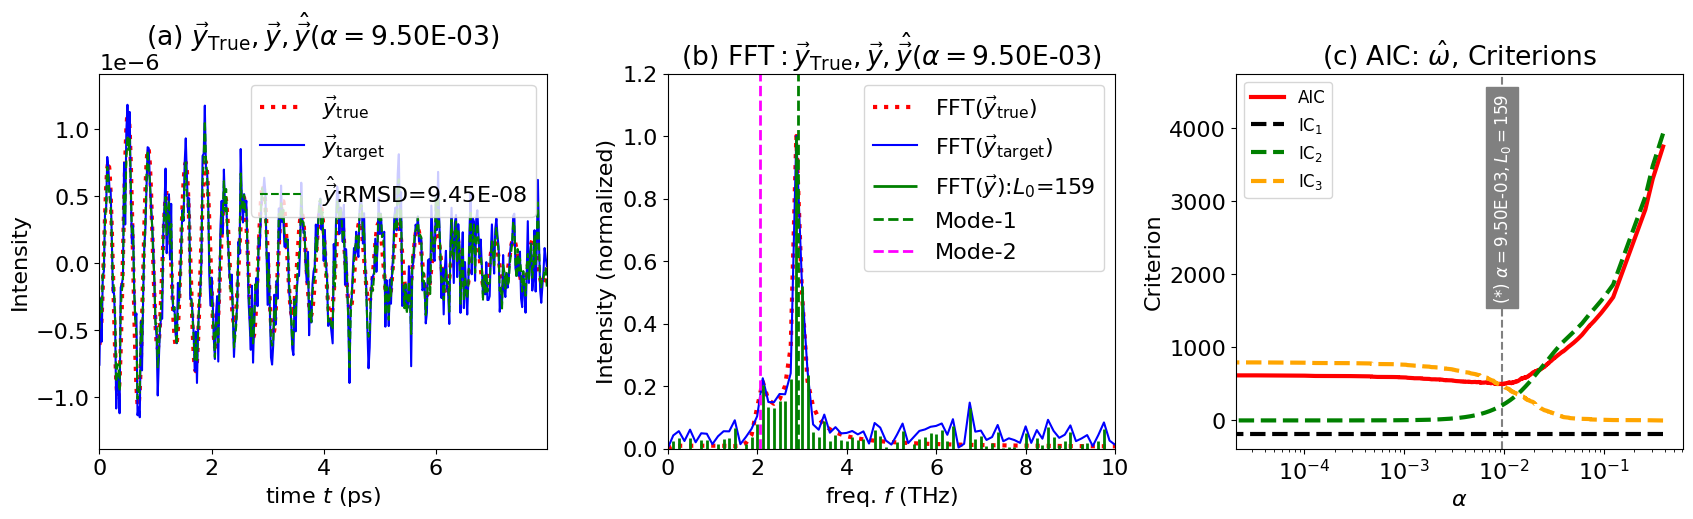

In [23]:
############################################
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
#
############################################
# 推定された $\alpha_{\rm AIC}$の解析結果のまとめ
fig = Grf_ICsurveySummary_v2( dictAICsurvey ) #, idx_=10 )
#
pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-Selected-summary-01.pdf'
fig.savefig( pdfname )

調査された $\alpha$ テーブルから抜粋して出力する。

idx_ =  0
$\alpha=$3.86E-01$, L_{0}=  1$


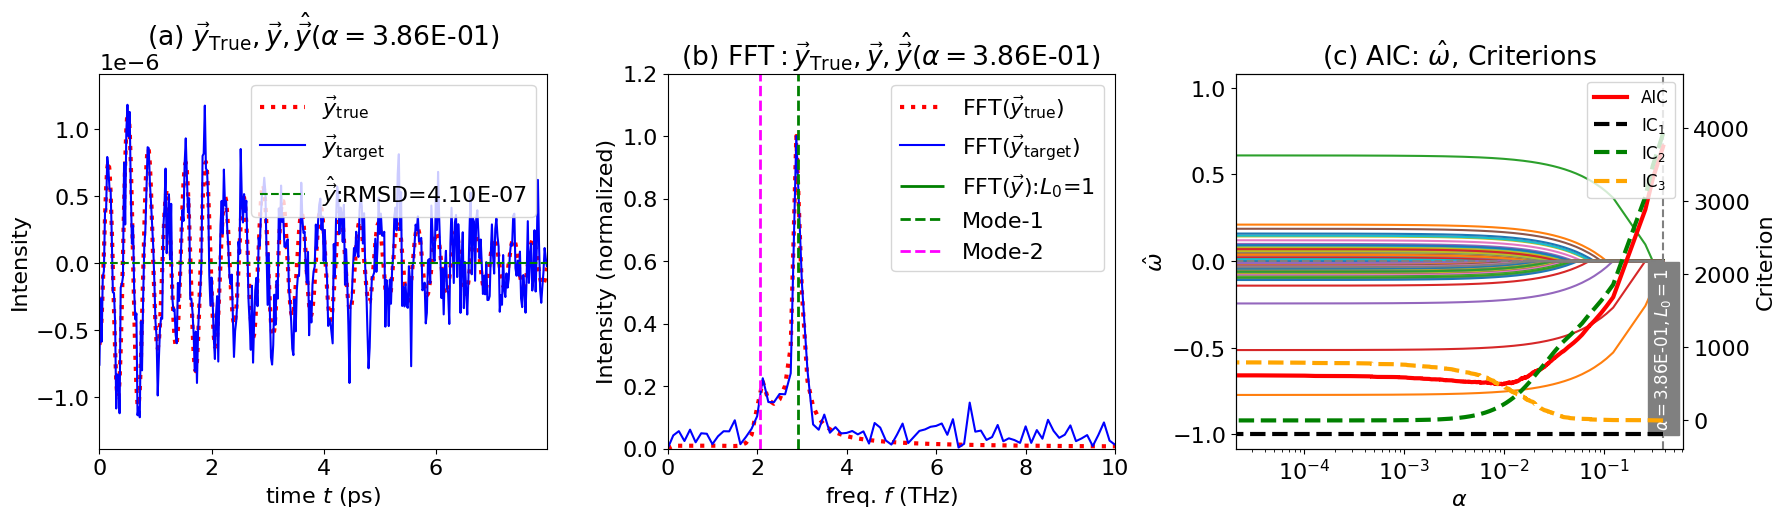

idx_ =  4
$\alpha=$1.05E-01$, L_{0}=  4$


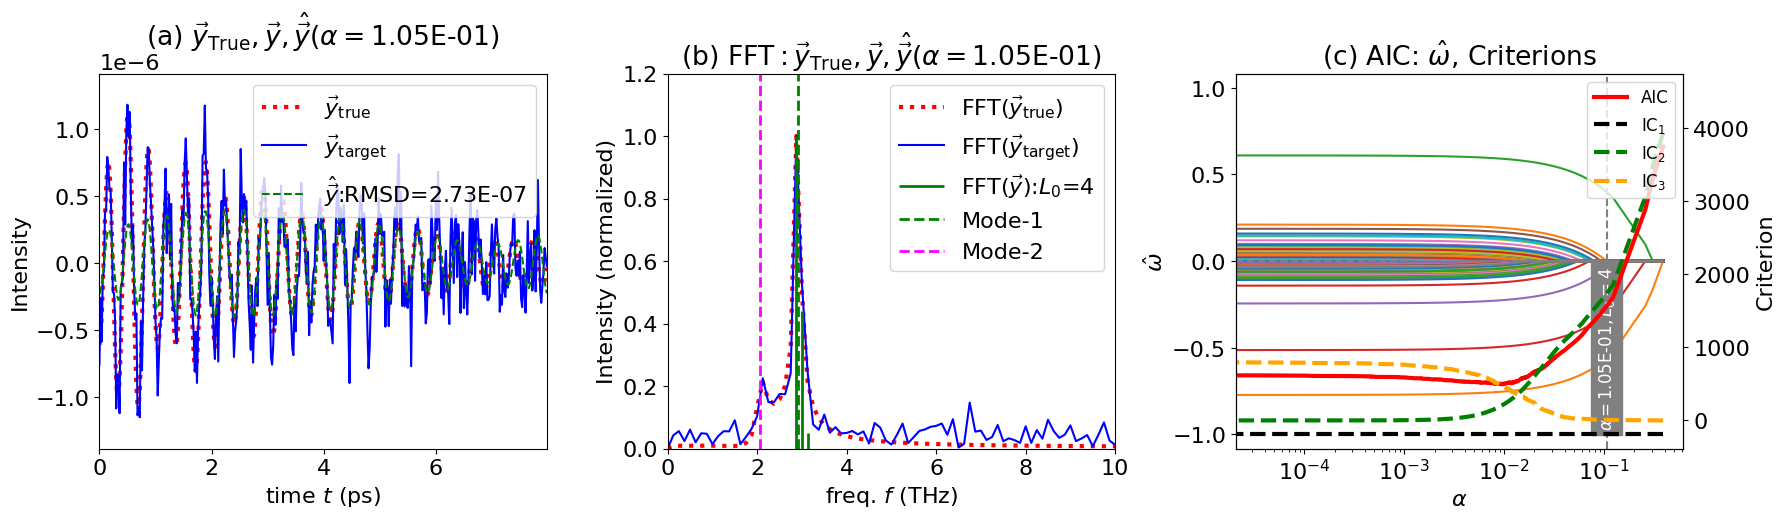

idx_ =  16
$\alpha=$4.59E-02$, L_{0}= 14$


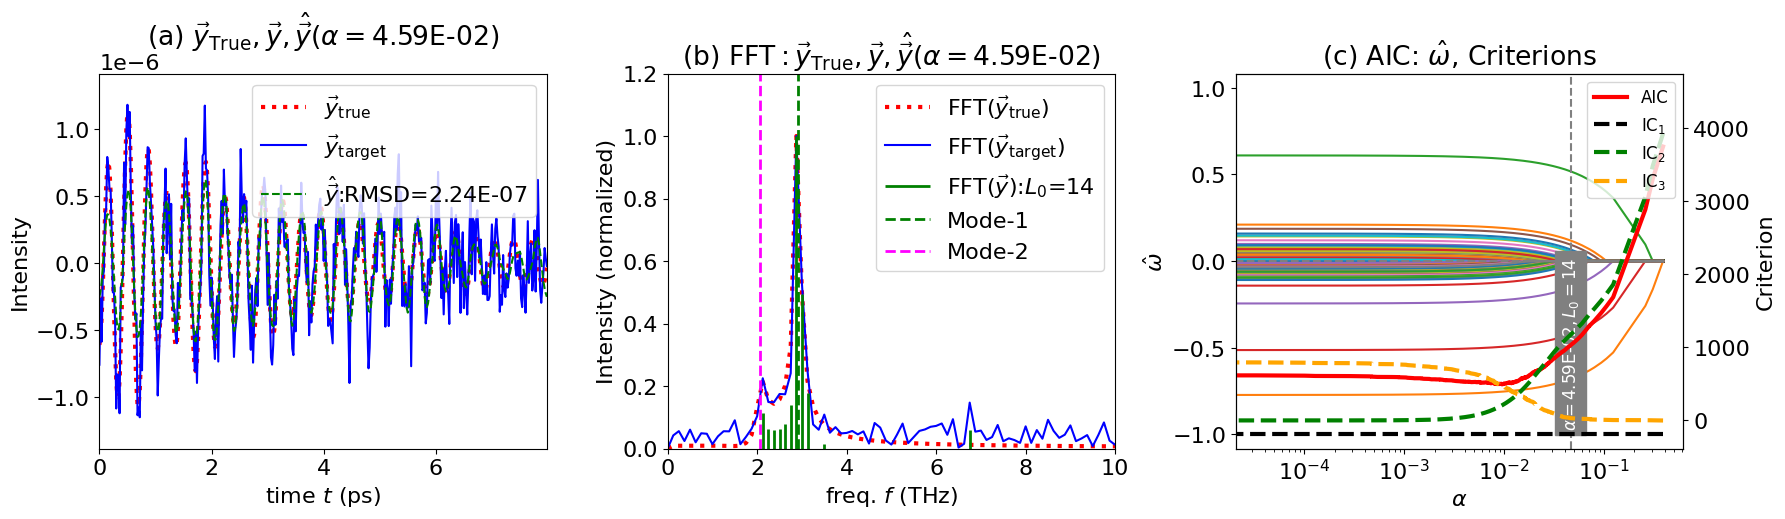

idx_ =  64
$\alpha=$2.68E-02$, L_{0}= 56$


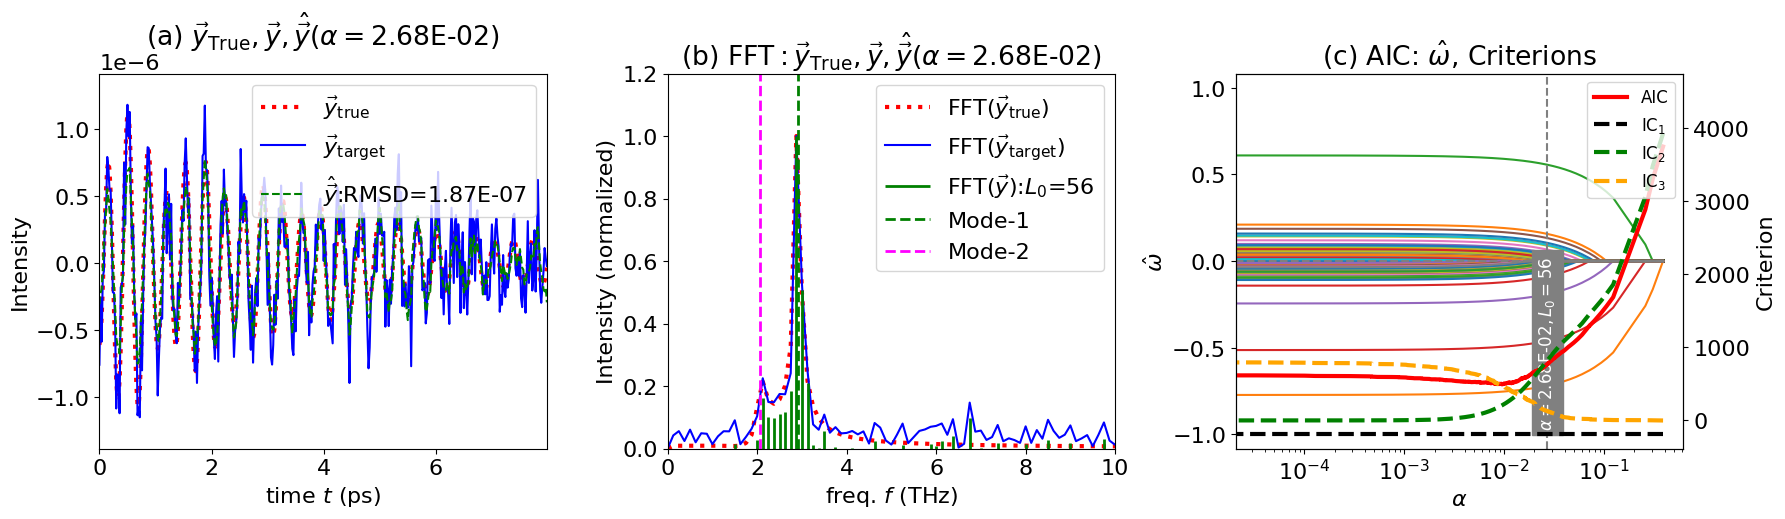

idx_ =  100
$\alpha=$2.16E-02$, L_{0}= 89$


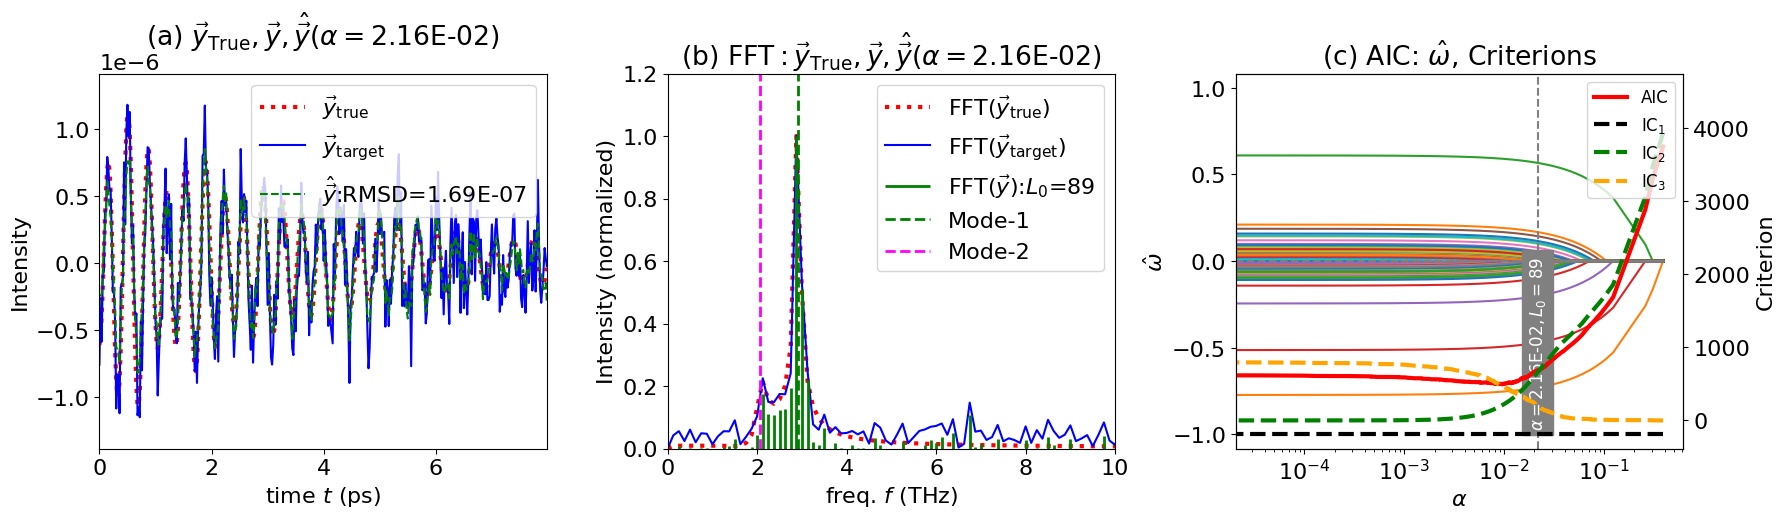

idx_ =  200
$\alpha=$1.17E-02$, L_{0}=146$


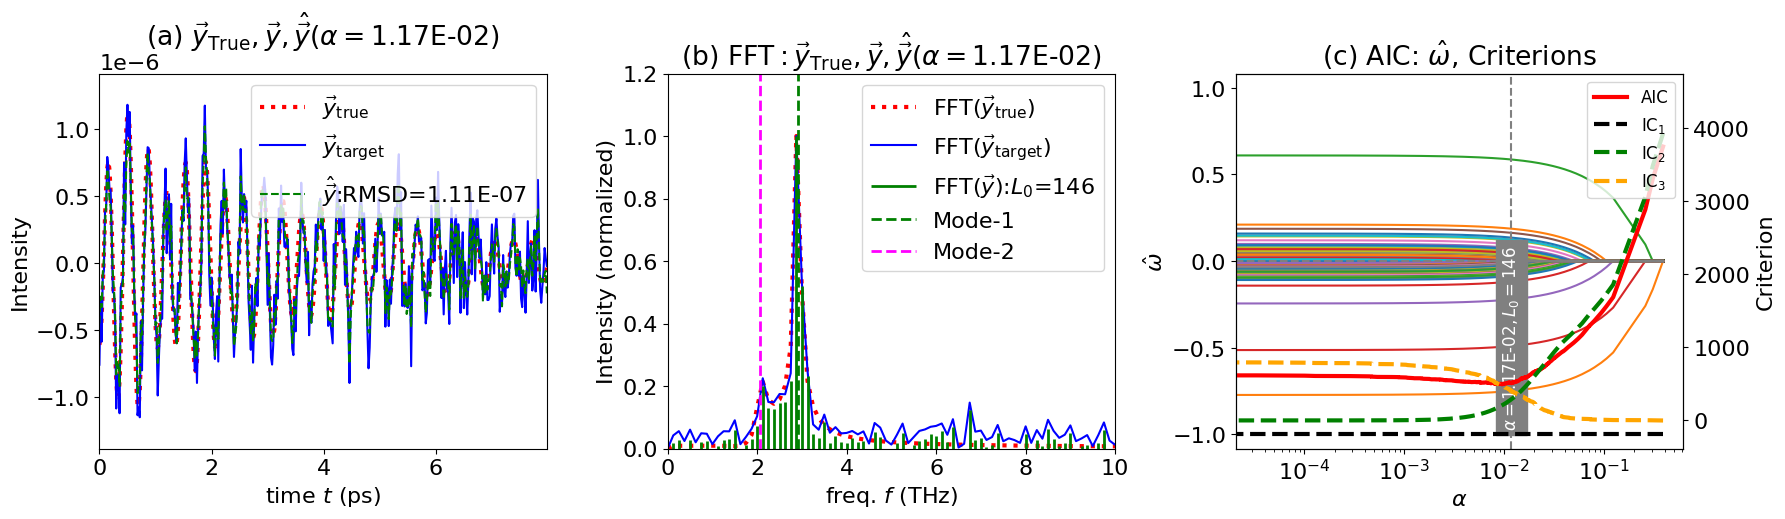

idx_ =  300
$\alpha=$5.91E-03$, L_{0}=186$


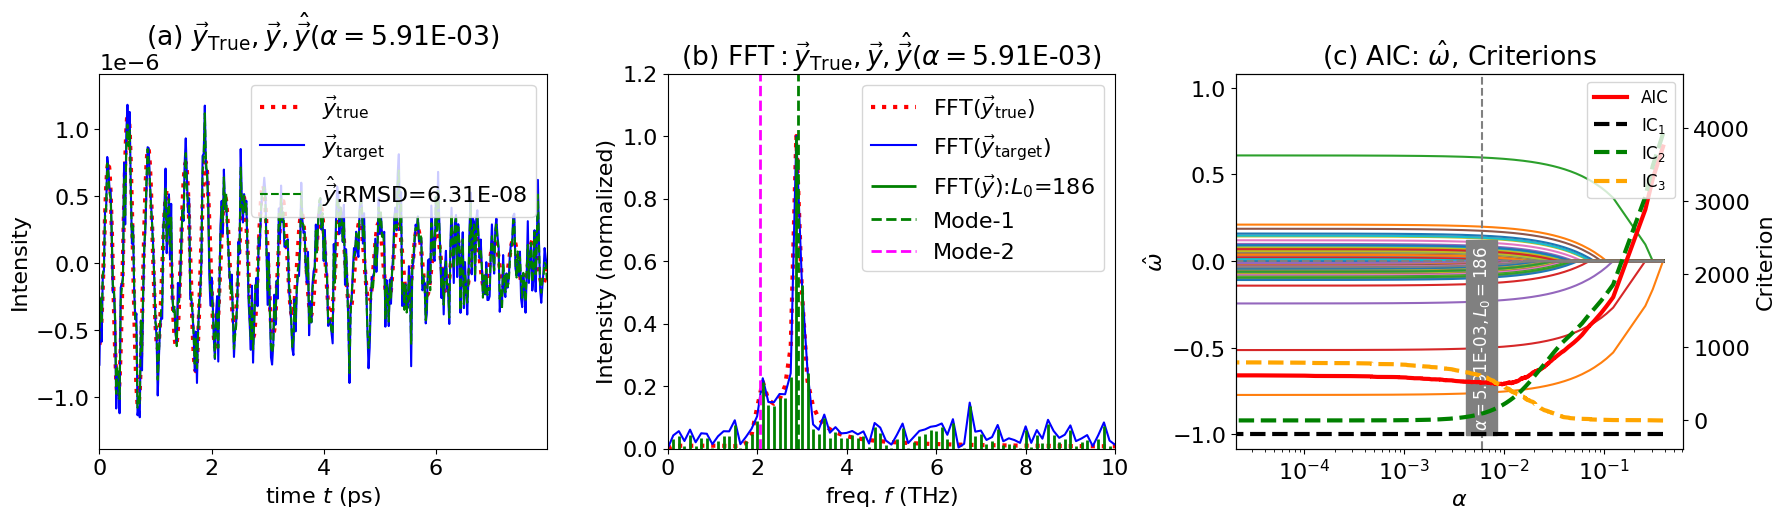

In [24]:
############################################
# 調査された $\alpha$ テーブルから20個程度抜粋して出力する。
#
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
alphas_   = dictAICsurvey[ 'alphas'   ]
#
idx_max   = len( alphas_ )
#
for idx_ in [0, 4, 16, 64, 100, 200, 300]:
  #
  fig = Grf_ICsurveySummary( dictAICsurvey, idx_=idx_ )
  #
  pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-%03d-summary-01.pdf' % idx_
  # print( pdfname )
  fig.savefig( pdfname )


---
BICの実行 (noise_varianceを指定せず、推定させてみる)

In [25]:
############################################
IC = 'bic' # 'aic'
############################################
# BICの実行
dictBIC = dictICriterion( IC, y_target, X )
# BIC : alpha=2.525E-02 : L0= 61 : RMSD_y=1.823E-07 : RMSD_fft=1.693E-02
# noise_var =  0.10194687245749737
#
# dictBIC = dictICriterion( IC, y_target, X, noise_variance=y_ss_var )
# BIC : alpha=4.594E-02 : L0= 14 : RMSD_y=2.244E-07 : RMSD_fft=2.525E-02
# noise_var =  0.23772288273764147
#
print( dictBIC.keys() )

-- BIC ------------------
BIC : alpha=2.525E-02 : L0= 61 : RMSD_y=1.823E-07 : RMSD_fft=1.693E-02 

noise_var =  0.10194687245749726
dict_keys(['y_target', 'y_target_ss', 'y_scaler', 'y_sacler_scale', 'y_sacler_mean', 'Xmat', 'fft_mag', 'IC_upper', 'IC_alpha', 'IC_coef', 'IC_intercept', 'IC_noise_var', 'alphas', 'criterions', 'IC_yreg', 'IC_yreg_RMSD', 'IC_fft_mag_RMSD', 'IC_L0'])


In [26]:
############################################
dictBICsurvey = dictICsurvey( dictBIC )
#
# dictBICsurvey = dictICsurvey( dictBIC, noise_variance=y_ss_var )
#
print( dictBICsurvey.keys() )

noise_variance = 1.0195E-01
IC_noise_var   = 1.0195E-01
  idx: alpha      : criterion  : L0  : fftRMSD    : RMSDtarget : RMSDtrue   : ICcheck    : IC_0       : IC_1       : IC_2      
    0: 3.8649E-01 : 3.7454E+03 :   1 : 8.3503E-02 : 4.1020E-07 : 3.6911E-07 : 3.7454E+03 : -1.7817E+02 : 3.9236E+03 : 0.0000E+00 
    1: 3.0474E-01 : 3.3080E+03 :   2 : 5.0442E-02 : 3.8632E-07 : 3.4106E-07 : 3.3080E+03 : -1.7817E+02 : 3.4802E+03 : 5.9915E+00 
    2: 2.5697E-01 : 2.8929E+03 :   2 : 5.0442E-02 : 3.6220E-07 : 3.1330E-07 : 2.8929E+03 : -1.7817E+02 : 3.0590E+03 : 1.1983E+01 
    3: 1.2249E-01 : 1.6975E+03 :   3 : 3.7774E-02 : 2.8225E-07 : 2.1856E-07 : 1.6975E+03 : -1.7817E+02 : 1.8577E+03 : 1.7974E+01 
    4: 1.0510E-01 : 1.5793E+03 :   4 : 3.6465E-02 : 2.7265E-07 : 2.0680E-07 : 1.5793E+03 : -1.7817E+02 : 1.7335E+03 : 2.3966E+01 
    5: 9.3127E-02 : 1.4921E+03 :   5 : 3.5032E-02 : 2.6523E-07 : 1.9651E-07 : 1.4921E+03 : -1.7817E+02 : 1.6403E+03 : 2.9957E+01 
    6: 7.9322E-02 : 1.3860E+03 :   6

推定された $\alpha_{\rm BIC}$の解析結果のまとめ

idx_ =  69
(*) $\alpha=$2.53E-02$, L_{0}= 61$


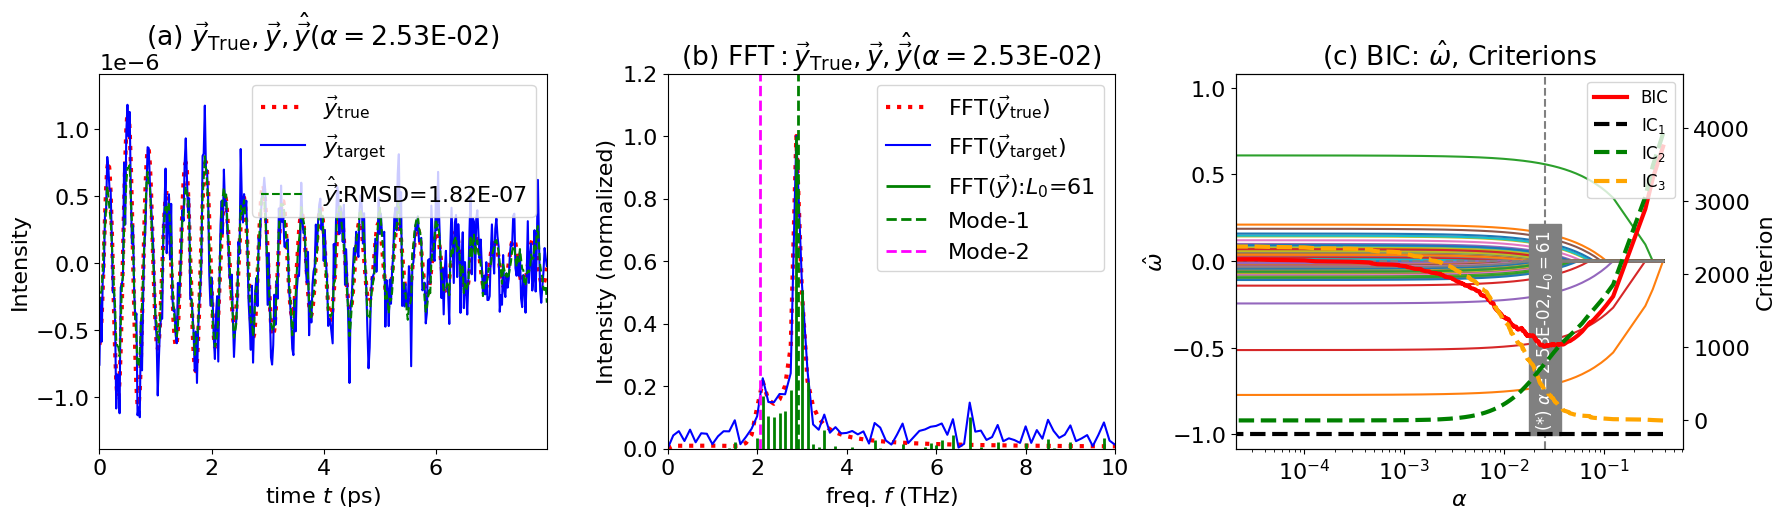

In [27]:
############################################
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
#
############################################
# 推定された $\alpha_{\rm AIC}$の解析結果のまとめ
fig = Grf_ICsurveySummary( dictBICsurvey ) #, idx_=10 )
#
pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-Selected-summary-02.pdf'
# print( pdfname )
fig.savefig( pdfname )

idx_ =  69
(*) $\alpha=$2.53E-02$, L_{0}= 61$


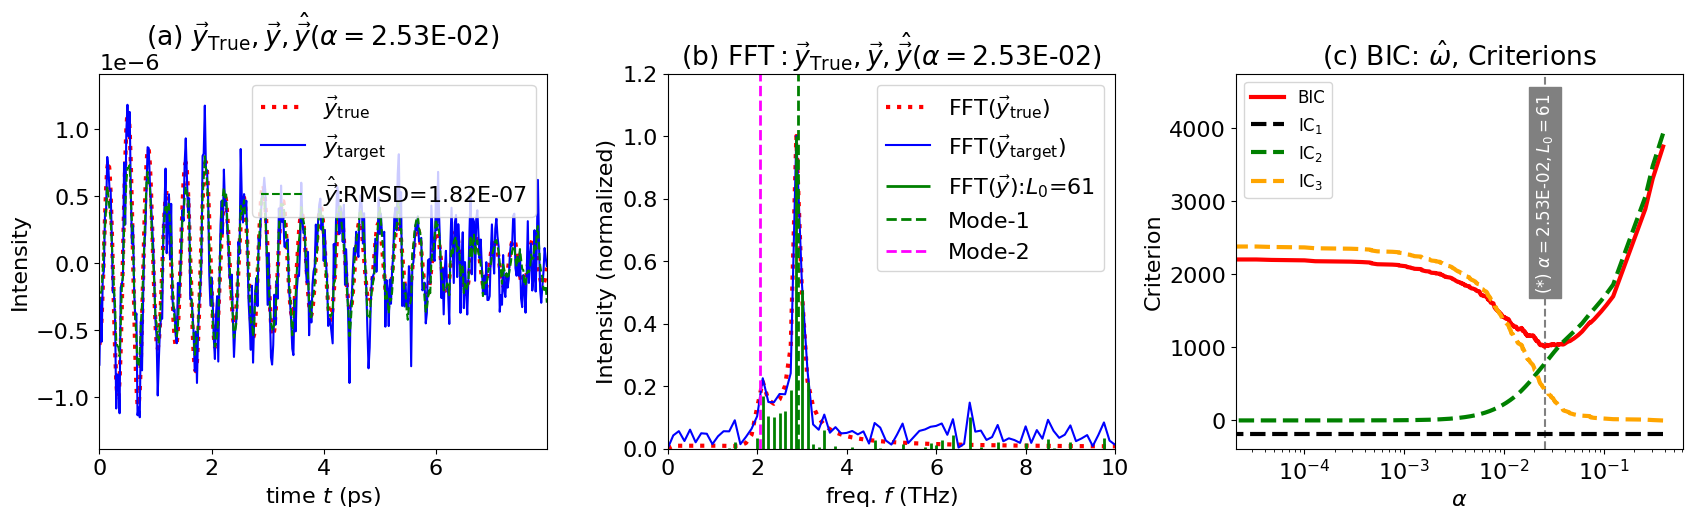

In [28]:
############################################
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
#
############################################
# 推定された $\alpha_{\rm AIC}$の解析結果のまとめ
fig = Grf_ICsurveySummary_v2( dictBICsurvey ) #, idx_=10 )
#
pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-Selected-summary-01.pdf'
# print( pdfname )
fig.savefig( pdfname )

調査された $\alpha$ テーブルから抜粋して出力する。

idx_ =  0
$\alpha=$3.86E-01$, L_{0}=  1$


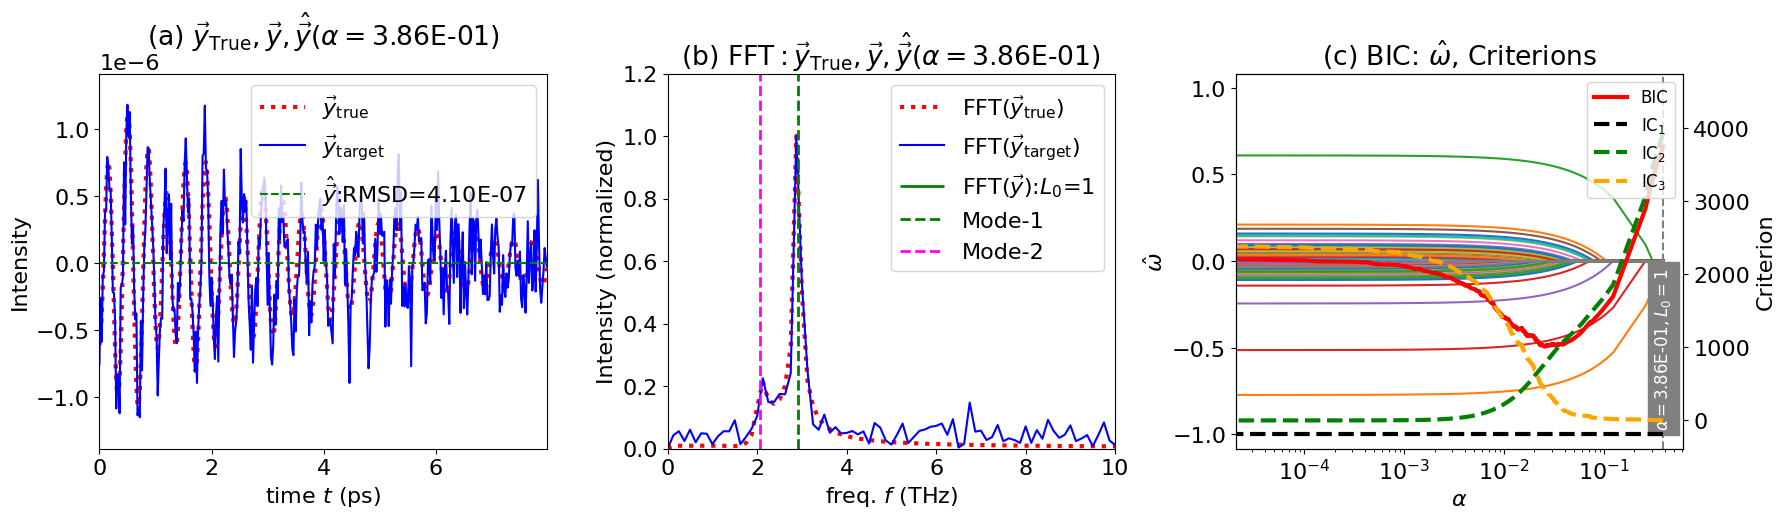

idx_ =  4
$\alpha=$1.05E-01$, L_{0}=  4$


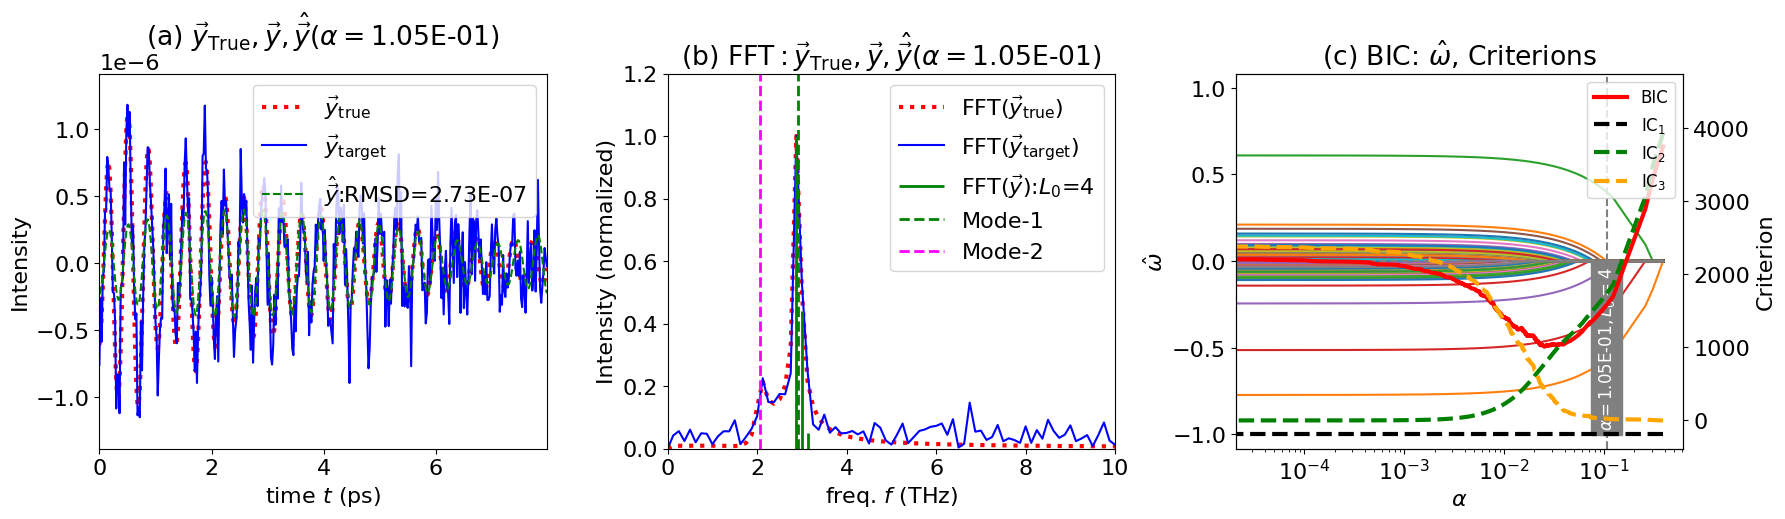

idx_ =  16
$\alpha=$4.59E-02$, L_{0}= 14$


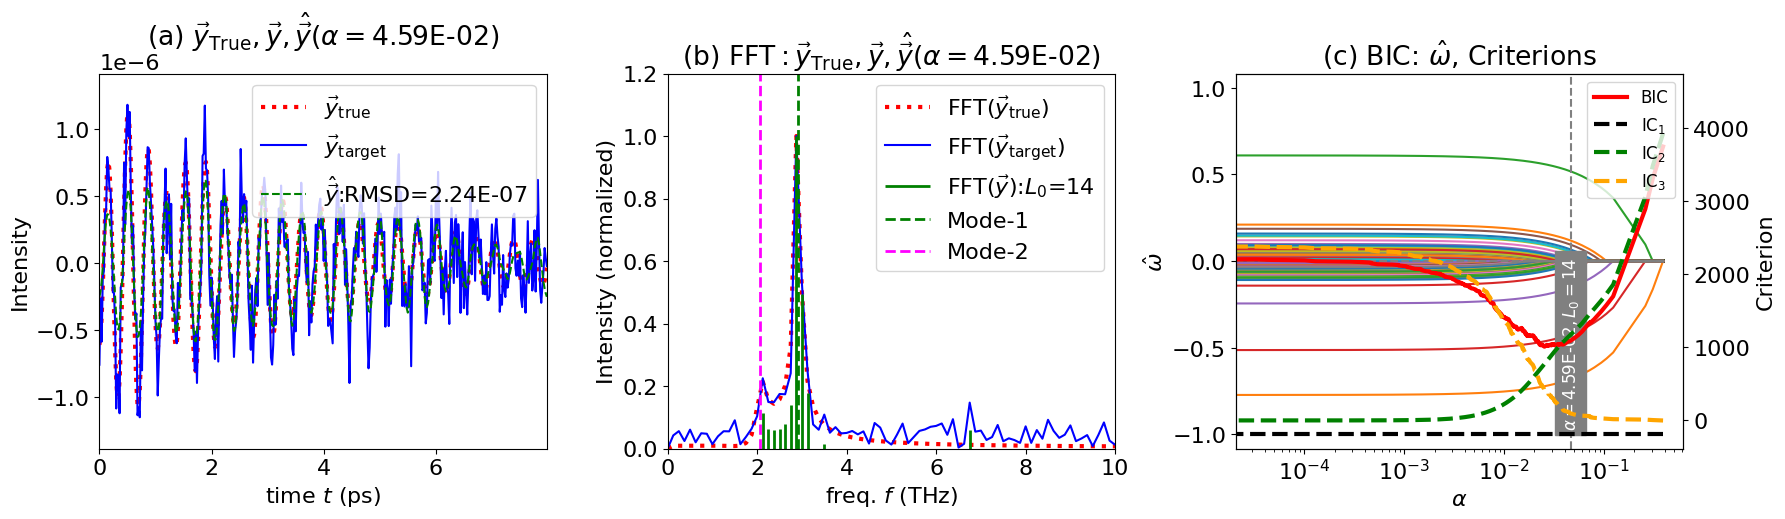

idx_ =  64
$\alpha=$2.68E-02$, L_{0}= 56$


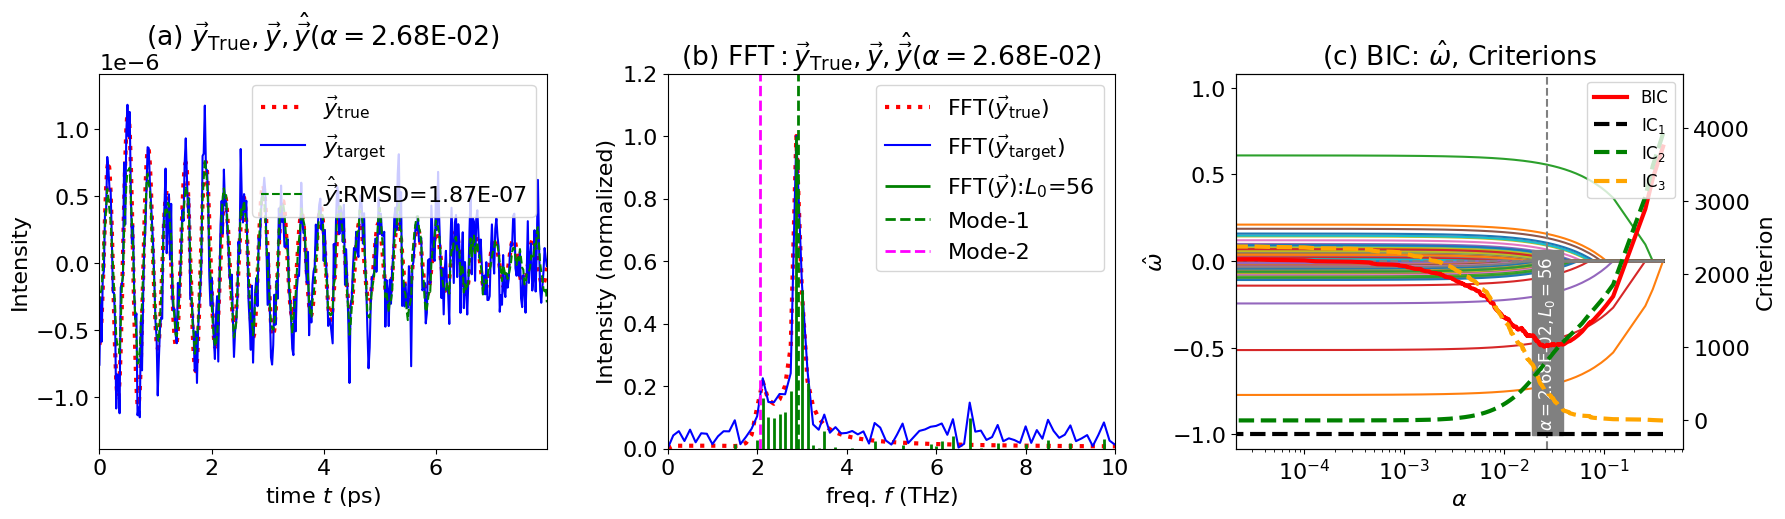

idx_ =  100
$\alpha=$2.16E-02$, L_{0}= 89$


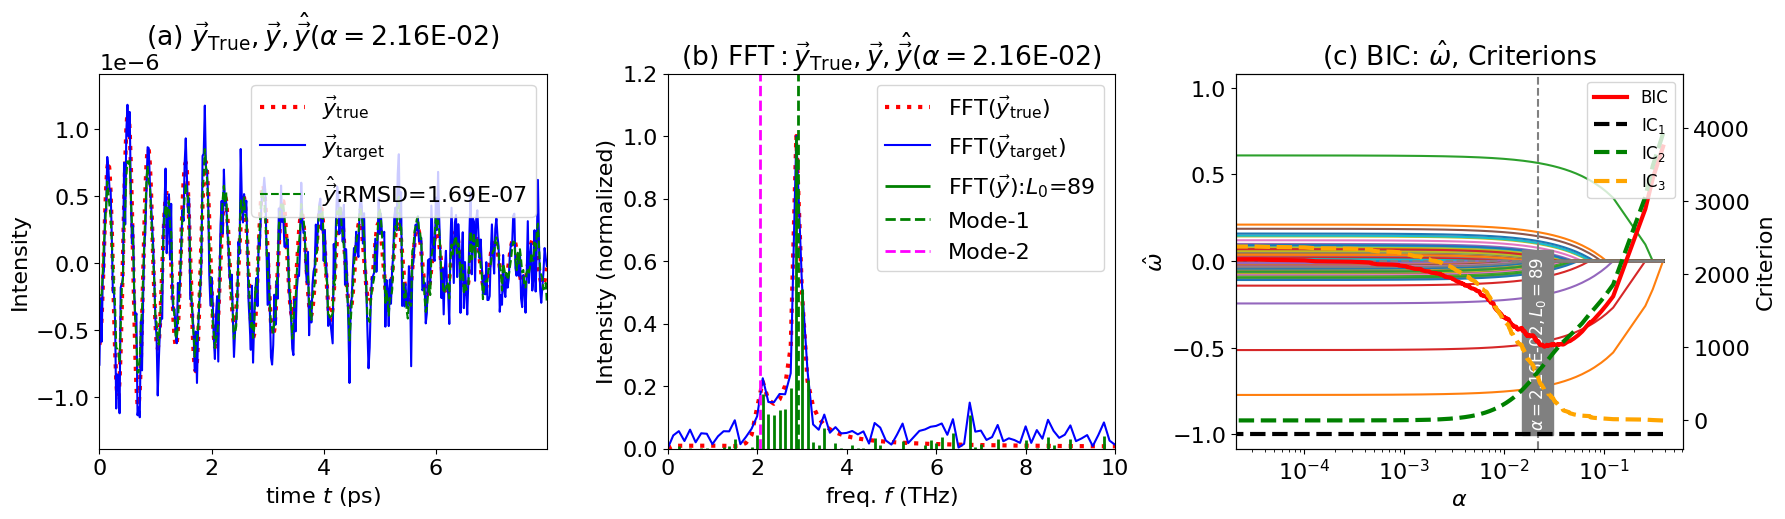

idx_ =  200
$\alpha=$1.17E-02$, L_{0}=146$


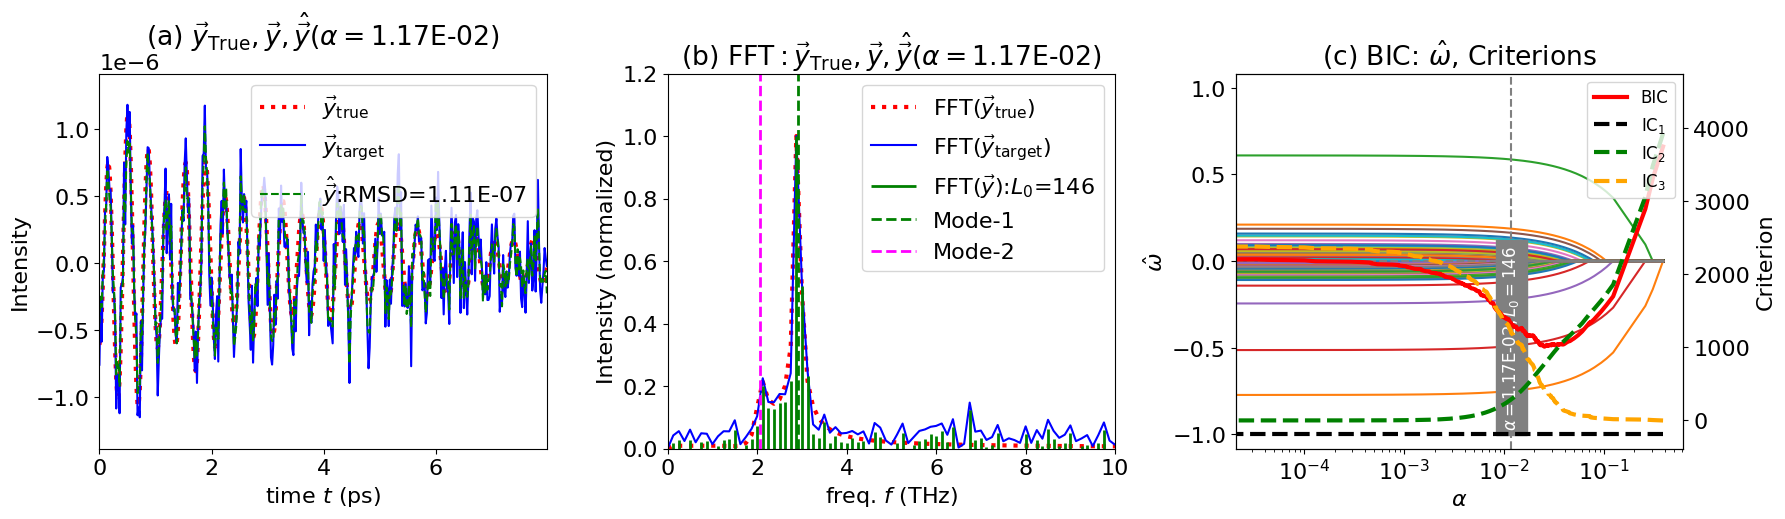

idx_ =  300
$\alpha=$5.91E-03$, L_{0}=186$


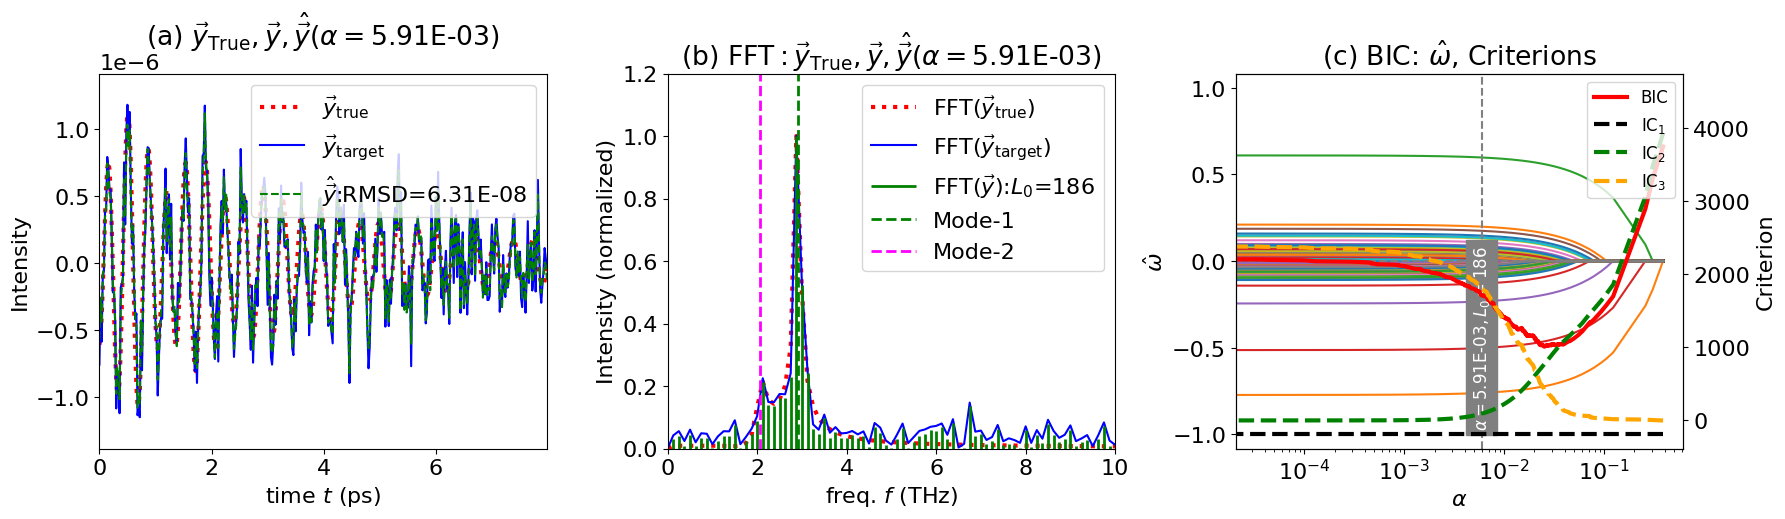

In [29]:
############################################
# 調査された $\alpha$ テーブルから20個程度抜粋して出力する。
#
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
alphas_   = dictBICsurvey[ 'alphas'   ]
#
idx_max   = len( alphas_ )
#
for idx_ in [0, 4, 16, 64, 100, 200, 300]:
  #
  fig = Grf_ICsurveySummary( dictBICsurvey, idx_=idx_ )
  #
  pdfname = FilePath + FileBaseName + '-' + IC_upper_ + '-%03d-summary-01.pdf' % idx_
  #
  fig.savefig( pdfname )